# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 4  
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 4]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 503.83697509765625
iteration 0 loss 457.8285827636719


iteration 500 loss 1.495562195777893


iteration 1000 loss 0.10936225205659866


iteration 1500 loss 0.05035647377371788


iteration 2000 loss 0.030157921835780144


iteration 2500 loss 0.019367830827832222


iteration 3000 loss 0.3342892527580261


iteration 3500 loss 0.015374526381492615


iteration 4000 loss 0.010312668047845364


iteration 4500 loss 0.0076436977833509445


iteration 5000 loss 0.025348562747240067


iteration 5500 loss 0.007714361418038607


iteration 6000 loss 0.005645773373544216


iteration 6500 loss 0.00449305959045887


iteration 7000 loss 0.004688618704676628


iteration 7500 loss 0.003742162138223648


iteration 8000 loss 0.0036719036288559437


iteration 8500 loss 0.0035841017961502075


iteration 9000 loss 0.003444309812039137


iteration 9500 loss 0.0032154680229723454


iteration 10000 loss 0.0029431674629449844


iteration 10500 loss 0.002696523442864418


iteration 11000 loss 0.00252063712105155


iteration 11500 loss 0.002347856992855668


iteration 12000 loss 0.0021974416449666023


iteration 12500 loss 0.002072524279356003


iteration 13000 loss 0.004629430826753378


iteration 13500 loss 0.0021846264135092497


iteration 14000 loss 0.0019889692775905132


iteration 14500 loss 0.0018798988312482834


iteration 15000 loss 0.001776547054760158


iteration 15500 loss 0.0016777252312749624


iteration 16000 loss 0.001585378427989781


iteration 16500 loss 0.0693787932395935


iteration 17000 loss 0.005816883873194456


iteration 17500 loss 0.0018741729436442256


iteration 18000 loss 0.0017559400293976068


iteration 18500 loss 0.0016390993259847164


iteration 19000 loss 0.0015042071463540196


iteration 19500 loss 0.001418612664565444


iteration 20000 loss 0.0013879346661269665


iteration 20500 loss 0.0013763896422460675


iteration 21000 loss 0.0013803222682327032


iteration 21500 loss 0.001457040780223906


iteration 22000 loss 0.0015259808860719204


iteration 22500 loss 0.008810700848698616


iteration 23000 loss 0.0010378045262768865


iteration 23500 loss 0.0010337838903069496


iteration 24000 loss 0.0010281343711540103


iteration 24500 loss 0.0010179480304941535


iteration 25000 loss 0.0010181148536503315


iteration 25500 loss 0.0010125242406502366


iteration 26000 loss 0.0009886815678328276


iteration 26500 loss 0.0009802209679037333


iteration 27000 loss 0.0010586389107629657


iteration 27500 loss 0.0009592062560841441


iteration 28000 loss 0.0008979408303275704


iteration 28500 loss 0.0008950722403824329


iteration 29000 loss 0.0009260860388167202


iteration 29500 loss 0.00105093396268785


iteration 30000 loss 0.0015473653329536319


iteration 30500 loss 0.0007311071967706084


iteration 31000 loss 0.0007434863364323974


iteration 31500 loss 0.0007539885700680315


iteration 32000 loss 0.0007595930946990848


iteration 32500 loss 0.0007782871252857149


iteration 33000 loss 0.00101597816683352


iteration 33500 loss 0.0629894807934761


iteration 34000 loss 0.0006492446991614997


iteration 34500 loss 0.0006478443974629045


iteration 35000 loss 0.0006543861236423254


iteration 35500 loss 0.0006684327963739634


iteration 36000 loss 0.0007098866044543684


iteration 36500 loss 0.0015893804375082254


iteration 37000 loss 0.0005863552214577794


iteration 37500 loss 0.0005929697654210031


iteration 38000 loss 0.0006312596960924566


iteration 38500 loss 0.0018824017606675625


iteration 39000 loss 0.0005666664219461381


iteration 39500 loss 0.0005706982337869704


iteration 40000 loss 0.00057410285808146


iteration 40500 loss 0.0005675939610227942


iteration 41000 loss 0.0005950623890385032


iteration 41500 loss 0.8784031867980957


iteration 42000 loss 0.0005294809816405177


iteration 42500 loss 0.0005202278844080865


iteration 43000 loss 0.0005208304501138628


iteration 43500 loss 0.0005331921856850386


iteration 44000 loss 0.00048200442688539624


iteration 44500 loss 0.0004854502622038126


iteration 45000 loss 0.0004934181924909353


iteration 45500 loss 0.0005327787948772311


iteration 46000 loss 0.00045420631067827344


iteration 46500 loss 0.0004751460801344365


iteration 47000 loss 0.0006009137723594904


iteration 47500 loss 0.0004488385166041553


iteration 48000 loss 0.00048402755055576563


iteration 48500 loss 0.00042817104258574545


iteration 49000 loss 0.0004407046071719378


iteration 49500 loss 0.00045100669376552105


iteration 50000 loss 0.0004339375300332904


iteration 50500 loss 0.0004325755580794066


iteration 51000 loss 0.000440097413957119


iteration 51500 loss 0.00046975791337899864


iteration 52000 loss 0.0003970179823227227


iteration 52500 loss 0.0004209222679492086


iteration 53000 loss 0.0004798651207238436


iteration 53500 loss 0.03249300271272659


iteration 54000 loss 0.0003913279506377876


iteration 54500 loss 0.00039722275687381625


iteration 55000 loss 0.0004084094543941319


iteration 55500 loss 0.0006864608731120825


iteration 56000 loss 0.00038400787161663175


iteration 56500 loss 0.00040083713247440755


iteration 57000 loss 0.00040414021350443363


iteration 57500 loss 0.00042915911762975156


iteration 58000 loss 0.007830698974430561


iteration 58500 loss 0.0003599400515668094


iteration 59000 loss 0.000363406928954646


iteration 59500 loss 0.00037109735421836376


iteration 60000 loss 0.00039890140760689974


iteration 60500 loss 0.000343917403370142


iteration 61000 loss 0.0003508619265630841


iteration 61500 loss 0.0003583426005207002


iteration 62000 loss 0.00037380208959802985


iteration 62500 loss 0.01358331274241209


iteration 63000 loss 0.0003341222763992846


iteration 63500 loss 0.000338602636475116


iteration 64000 loss 0.000344968429999426


iteration 64500 loss 0.000353996641933918


iteration 65000 loss 0.0003424281894695014


iteration 65500 loss 0.0003444701724220067


iteration 66000 loss 0.00039835713687352836


iteration 66500 loss 0.0003141725610475987


iteration 67000 loss 0.00032275757985189557


iteration 67500 loss 0.0003335144429001957


iteration 68000 loss 0.0007168800220824778


iteration 68500 loss 0.0003123846254311502


iteration 69000 loss 0.0003128862881567329


iteration 69500 loss 0.00032171676866710186


iteration 70000 loss 0.0003597410977818072


iteration 70500 loss 0.000299901730613783


iteration 71000 loss 0.00030652436544187367


iteration 71500 loss 0.00031004022457636893


iteration 72000 loss 0.00032393596484325826


iteration 72500 loss 0.00029457369237206876


iteration 73000 loss 0.0002998584823217243


iteration 73500 loss 0.0003076790308114141


iteration 74000 loss 0.0003284449630882591


iteration 74500 loss 0.00028681650292128325


iteration 75000 loss 0.000292609358439222


iteration 75500 loss 0.00031545228557661176


iteration 76000 loss 0.00028359307907521725


iteration 76500 loss 0.0002899555256590247


iteration 77000 loss 0.00031610712176188827


iteration 77500 loss 0.0003471271775197238


iteration 78000 loss 0.0003049774677492678


iteration 78500 loss 0.00042738323099911213


iteration 79000 loss 0.0002753355074673891


iteration 79500 loss 0.000286180671537295


iteration 80000 loss 0.00033202231861650944


iteration 80500 loss 0.00027913646772503853


iteration 81000 loss 0.0002751022402662784


iteration 81500 loss 0.0002773794694803655


iteration 82000 loss 0.00027986333589069545


iteration 82500 loss 0.000290393247269094


iteration 83000 loss 0.02874593995511532


iteration 83500 loss 0.00027609014068730175


iteration 84000 loss 0.0003971317782998085


iteration 84500 loss 0.0002667079970706254


iteration 85000 loss 0.0002745926904026419


iteration 85500 loss 0.0002928366884589195


iteration 86000 loss 0.00028709060279652476


iteration 86500 loss 0.00027350831078365445


iteration 87000 loss 0.00032814941368997097


iteration 87500 loss 0.0002545518218539655


iteration 88000 loss 0.00026025212719105184


iteration 88500 loss 0.0002701360499486327


iteration 89000 loss 0.0004769394872710109


iteration 89500 loss 0.00025049300165846944


iteration 90000 loss 0.00025726263993419707


iteration 90500 loss 0.00026411536964587867


iteration 91000 loss 0.0002741294738370925


iteration 91500 loss 0.014951118268072605


iteration 92000 loss 0.00024634681176394224


iteration 92500 loss 0.000250189914368093


iteration 93000 loss 0.0002545870665926486


iteration 93500 loss 0.0002492939820513129


iteration 94000 loss 0.00025042236666195095


iteration 94500 loss 0.0002574973623268306


iteration 95000 loss 0.0004789189260918647


iteration 95500 loss 0.00023950933245941997


iteration 96000 loss 0.0002493406645953655


iteration 96500 loss 0.0002862798282876611


iteration 97000 loss 0.0002409044245723635


iteration 97500 loss 0.0002504671865608543


iteration 98000 loss 0.0009851184440776706


iteration 98500 loss 0.0002439503587083891


iteration 99000 loss 0.00025124839157797396


iteration 99500 loss 0.0002704649814404547


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0002328942937310785


iteration 100500 loss 0.00023110909387469292


iteration 101000 loss 0.00022899975010659546


iteration 101500 loss 0.00022652442567050457


iteration 102000 loss 0.0002236523141618818


iteration 102500 loss 0.0002203355252277106


iteration 103000 loss 0.00021650853159371763


iteration 103500 loss 0.00021207303507253528


iteration 104000 loss 0.00020704432972706854


iteration 104500 loss 0.00020132664940319955


iteration 105000 loss 0.00019677128875628114


iteration 105500 loss 0.0002664068015292287


iteration 106000 loss 0.00018858395924326032


iteration 106500 loss 0.0001851214619819075


iteration 107000 loss 0.0001818918826756999


iteration 107500 loss 0.00017854060570243746


iteration 108000 loss 0.00017588971240911633


iteration 108500 loss 0.00017310310795437545


iteration 109000 loss 0.00017033629410434514


iteration 109500 loss 0.0001681597641436383


iteration 110000 loss 0.0001656555978115648


iteration 110500 loss 0.0001638830144656822


iteration 111000 loss 0.0001693217782303691


iteration 111500 loss 0.00015956144488882273


iteration 112000 loss 0.00015762270777486265


iteration 112500 loss 0.00015561595500912517


iteration 113000 loss 0.00015382457058876753


iteration 113500 loss 0.00021133283735252917


iteration 114000 loss 0.0002896143705584109


iteration 114500 loss 0.00014861141971778125


iteration 115000 loss 0.00014705468493048102


iteration 115500 loss 0.00014541702694259584


iteration 116000 loss 0.00014419987564906478


iteration 116500 loss 0.0003897954593412578


iteration 117000 loss 0.00014131319767329842


iteration 117500 loss 0.00013990704610478133


iteration 118000 loss 0.0001385514042340219


iteration 118500 loss 0.0001373381819576025


iteration 119000 loss 0.00013599942030850798


iteration 119500 loss 0.00013505549577530473


iteration 120000 loss 0.00013385925558395684


iteration 120500 loss 0.00013300204591359943


iteration 121000 loss 0.00013163371477276087


iteration 121500 loss 0.0001306642807321623


iteration 122000 loss 0.0001295743859373033


iteration 122500 loss 0.00012855191016569734


iteration 123000 loss 0.0001276271796086803


iteration 123500 loss 0.00013051675341557711


iteration 124000 loss 0.00012553906708490103


iteration 124500 loss 0.00026055730995722115


iteration 125000 loss 0.00013135894550941885


iteration 125500 loss 0.00012255494948476553


iteration 126000 loss 0.00012178142060292885


iteration 126500 loss 0.00012079734733561054


iteration 127000 loss 0.00012004812742816284


iteration 127500 loss 0.00011921962141059339


iteration 128000 loss 0.00011828484275611117


iteration 128500 loss 0.0001175895522464998


iteration 129000 loss 0.00011678077862598002


iteration 129500 loss 0.00011603353050304577


iteration 130000 loss 0.00011519990948727354


iteration 130500 loss 0.00011451251339167356


iteration 131000 loss 0.00011401569645386189


iteration 131500 loss 0.00011304731015115976


iteration 132000 loss 0.00011234598059672862


iteration 132500 loss 0.00011167061165906489


iteration 133000 loss 0.00011089665349572897


iteration 133500 loss 0.00011030784662580118


iteration 134000 loss 0.00010964951070491225


iteration 134500 loss 0.0003328684833832085


iteration 135000 loss 0.00010829844541149214


iteration 135500 loss 0.00011348148109391332


iteration 136000 loss 0.00010701837163651362


iteration 136500 loss 0.00010639517131494358


iteration 137000 loss 0.00010581636161077768


iteration 137500 loss 0.00010530329745961353


iteration 138000 loss 0.00010458090400788933


iteration 138500 loss 0.00010404858039692044


iteration 139000 loss 0.00010350965021643788


iteration 139500 loss 0.00010287069744663313


iteration 140000 loss 0.00010235598165309057


iteration 140500 loss 0.00010183922859141603


iteration 141000 loss 0.00020733087148983032


iteration 141500 loss 0.00010073082376038656


iteration 142000 loss 0.00010023259528679773


iteration 142500 loss 9.97344686766155e-05


iteration 143000 loss 9.97711977106519e-05


iteration 143500 loss 9.88072351901792e-05


iteration 144000 loss 9.826240420807153e-05


iteration 144500 loss 9.7976706456393e-05


iteration 145000 loss 9.713727922644466e-05


iteration 145500 loss 9.66816078289412e-05


iteration 146000 loss 9.617520845495164e-05


iteration 146500 loss 9.572925046086311e-05


iteration 147000 loss 9.528614464215934e-05


iteration 147500 loss 0.00010188089072471485


iteration 148000 loss 9.434908861294389e-05


iteration 148500 loss 9.392965876031667e-05


iteration 149000 loss 9.349849278805777e-05


iteration 149500 loss 0.00022395812266040593


iteration 150000 loss 9.259537182515487e-05


iteration 150500 loss 9.217410843120888e-05


iteration 151000 loss 9.178615437122062e-05


iteration 151500 loss 9.167847747448832e-05


iteration 152000 loss 9.090914682019502e-05


iteration 152500 loss 9.053832764038816e-05


iteration 153000 loss 9.01411403901875e-05


iteration 153500 loss 8.975262608146295e-05


iteration 154000 loss 8.951097697718069e-05


iteration 154500 loss 0.0005144451279193163


iteration 155000 loss 0.00018562005425337702


iteration 155500 loss 8.817169145913795e-05


iteration 156000 loss 8.778803021414205e-05


iteration 156500 loss 8.741632336750627e-05


iteration 157000 loss 8.739117038203403e-05


iteration 157500 loss 9.05360939214006e-05


iteration 158000 loss 8.624920883448794e-05


iteration 158500 loss 8.588535274611786e-05


iteration 159000 loss 8.554122177883983e-05


iteration 159500 loss 8.518897084286436e-05


iteration 160000 loss 8.48548297653906e-05


iteration 160500 loss 8.449410233879462e-05


iteration 161000 loss 8.416920900344849e-05


iteration 161500 loss 8.381050429306924e-05


iteration 162000 loss 8.347940456587821e-05


iteration 162500 loss 8.31319994176738e-05


iteration 163000 loss 8.2802762335632e-05


iteration 163500 loss 8.248238009400666e-05


iteration 164000 loss 8.218990114983171e-05


iteration 164500 loss 8.196011913241819e-05


iteration 165000 loss 8.151696965796873e-05


iteration 165500 loss 8.121250721160322e-05


iteration 166000 loss 8.091936615528539e-05


iteration 166500 loss 8.058745152084157e-05


iteration 167000 loss 8.028472802834585e-05


iteration 167500 loss 7.999229273991659e-05


iteration 168000 loss 8.317573519889265e-05


iteration 168500 loss 8.14486265880987e-05


iteration 169000 loss 7.979808287927881e-05


iteration 169500 loss 7.890934648457915e-05


iteration 170000 loss 0.0024676567409187555


iteration 170500 loss 7.818038284312934e-05


iteration 171000 loss 7.788454968249425e-05


iteration 171500 loss 8.036731742322445e-05


iteration 172000 loss 7.819137681508437e-05


iteration 172500 loss 0.00010859212488867342


iteration 173000 loss 0.00016007463273126632


iteration 173500 loss 7.649193139513955e-05


iteration 174000 loss 7.622392877237871e-05


iteration 174500 loss 7.593711779918522e-05


iteration 175000 loss 7.565291889477521e-05


iteration 175500 loss 0.00015912219532765448


iteration 176000 loss 7.5141666457057e-05


iteration 176500 loss 7.488885603379458e-05


iteration 177000 loss 7.463980000466108e-05


iteration 177500 loss 7.817231380613521e-05


iteration 178000 loss 0.0030799161177128553


iteration 178500 loss 7.636993541382253e-05


iteration 179000 loss 7.508115231757984e-05


iteration 179500 loss 7.363346230704337e-05


iteration 180000 loss 0.00025768799241632223


iteration 180500 loss 7.298571290448308e-05


iteration 181000 loss 7.261100108735263e-05


iteration 181500 loss 7.236693636514246e-05


iteration 182000 loss 7.213125354610384e-05


iteration 182500 loss 7.19880627002567e-05


iteration 183000 loss 7.164133421611041e-05


iteration 183500 loss 7.139998342609033e-05


iteration 184000 loss 7.115532935131341e-05


iteration 184500 loss 7.092258601915091e-05


iteration 185000 loss 7.069786806823686e-05


iteration 185500 loss 7.046473183436319e-05


iteration 186000 loss 7.02438919688575e-05


iteration 186500 loss 7.096987246768549e-05


iteration 187000 loss 6.982790364418179e-05


iteration 187500 loss 6.959335587453097e-05


iteration 188000 loss 6.936509453225881e-05


iteration 188500 loss 6.915638368809596e-05


iteration 189000 loss 6.895667320350185e-05


iteration 189500 loss 6.876391125842929e-05


iteration 190000 loss 6.852054502815008e-05


iteration 190500 loss 6.831034988863394e-05


iteration 191000 loss 6.815460801590234e-05


iteration 191500 loss 0.00037131557473912835


iteration 192000 loss 6.765774742234498e-05


iteration 192500 loss 6.74623588565737e-05


iteration 193000 loss 6.725495040882379e-05


iteration 193500 loss 6.70543740852736e-05


iteration 194000 loss 6.686168489977717e-05


iteration 194500 loss 6.66484484099783e-05


iteration 195000 loss 6.644921086262912e-05


iteration 195500 loss 0.0014905615244060755


iteration 196000 loss 6.882495654281229e-05


iteration 196500 loss 6.588905671378598e-05


iteration 197000 loss 6.565685180248693e-05


iteration 197500 loss 6.545807991642505e-05


iteration 198000 loss 6.525338540086523e-05


iteration 198500 loss 6.50675137876533e-05


iteration 199000 loss 6.488332292065024e-05


iteration 199500 loss 6.470639345934615e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 6.480806041508913e-05


iteration 200500 loss 6.452059460571036e-05


iteration 201000 loss 6.449087959481403e-05


iteration 201500 loss 6.445329927373677e-05


iteration 202000 loss 6.440602737711743e-05


iteration 202500 loss 6.434763054130599e-05


iteration 203000 loss 6.427303742384538e-05


iteration 203500 loss 6.417951226467267e-05


iteration 204000 loss 6.406002648873255e-05


iteration 204500 loss 6.390858470695093e-05


iteration 205000 loss 6.371759809553623e-05


iteration 205500 loss 6.352625496219844e-05


iteration 206000 loss 6.334736099233851e-05


iteration 206500 loss 6.315792415989563e-05


iteration 207000 loss 6.298311200225726e-05


iteration 207500 loss 6.28039488219656e-05


iteration 208000 loss 6.262955866986886e-05


iteration 208500 loss 6.245107215363532e-05


iteration 209000 loss 6.22743318672292e-05


iteration 209500 loss 6.211215077200904e-05


iteration 210000 loss 6.19360216660425e-05


iteration 210500 loss 6.175424641696736e-05


iteration 211000 loss 6.159543409012258e-05


iteration 211500 loss 6.142268830444664e-05


iteration 212000 loss 6.125354411778972e-05


iteration 212500 loss 6.107456283643842e-05


iteration 213000 loss 6.091778050176799e-05


iteration 213500 loss 6.074730117688887e-05


iteration 214000 loss 6.057876089471392e-05


iteration 214500 loss 6.042780296411365e-05


iteration 215000 loss 6.026169648976065e-05


iteration 215500 loss 6.0111586208222434e-05


iteration 216000 loss 7.942409138195217e-05


iteration 216500 loss 5.9798483562190086e-05


iteration 217000 loss 5.963669900665991e-05


iteration 217500 loss 5.9485344536369666e-05


iteration 218000 loss 5.932671410846524e-05


iteration 218500 loss 5.919920658925548e-05


iteration 219000 loss 5.932430940447375e-05


iteration 219500 loss 5.8889680076390505e-05


iteration 220000 loss 5.8742985856952146e-05


iteration 220500 loss 5.8594690926838666e-05


iteration 221000 loss 5.8450339565752074e-05


iteration 221500 loss 5.831638554809615e-05


iteration 222000 loss 5.816314660478383e-05


iteration 222500 loss 5.8024117606692016e-05


iteration 223000 loss 5.787564441561699e-05


iteration 223500 loss 5.7731733249966055e-05


iteration 224000 loss 5.7591983932070434e-05


iteration 224500 loss 5.7467179431114346e-05


iteration 225000 loss 5.7310280681122094e-05


iteration 225500 loss 5.719349064747803e-05


iteration 226000 loss 5.7049404858844355e-05


iteration 226500 loss 5.692276681656949e-05


iteration 227000 loss 5.679509922629222e-05


iteration 227500 loss 5.665062053594738e-05


iteration 228000 loss 5.7131550420308486e-05


iteration 228500 loss 5.63799258088693e-05


iteration 229000 loss 6.487103382823989e-05


iteration 229500 loss 5.611563756247051e-05


iteration 230000 loss 5.596838309429586e-05


iteration 230500 loss 5.585983308264986e-05


iteration 231000 loss 5.5734621128067374e-05


iteration 231500 loss 5.560310819419101e-05


iteration 232000 loss 5.547565160668455e-05


iteration 232500 loss 5.5343662097584456e-05


iteration 233000 loss 5.520598642760888e-05


iteration 233500 loss 5.5093347327783704e-05


iteration 234000 loss 5.497496749740094e-05


iteration 234500 loss 5.484527355292812e-05


iteration 235000 loss 5.4711508710170165e-05


iteration 235500 loss 5.459899330162443e-05


iteration 236000 loss 5.447849616757594e-05


iteration 236500 loss 5.435070852399804e-05


iteration 237000 loss 5.424679329735227e-05


iteration 237500 loss 5.411513848230243e-05


iteration 238000 loss 5.400825466495007e-05


iteration 238500 loss 5.389118814491667e-05


iteration 239000 loss 5.37679843546357e-05


iteration 239500 loss 5.3665116865886375e-05


iteration 240000 loss 5.353439337341115e-05


iteration 240500 loss 5.342863732948899e-05


iteration 241000 loss 5.3305808251025155e-05


iteration 241500 loss 5.3195541113382205e-05


iteration 242000 loss 5.308315667207353e-05


iteration 242500 loss 5.296200470183976e-05


iteration 243000 loss 5.2858547860523686e-05


iteration 243500 loss 7.417808228638023e-05


iteration 244000 loss 5.263708590064198e-05


iteration 244500 loss 5.2520954341161996e-05


iteration 245000 loss 5.239935853751376e-05


iteration 245500 loss 5.228929876466282e-05


iteration 246000 loss 5.2167088142596185e-05


iteration 246500 loss 5.2069757657591254e-05


iteration 247000 loss 5.195510311750695e-05


iteration 247500 loss 5.1837650971719995e-05


iteration 248000 loss 5.1729784900089726e-05


iteration 248500 loss 6.724901322741061e-05


iteration 249000 loss 5.1508628530427814e-05


iteration 249500 loss 5.139436689205468e-05


iteration 250000 loss 5.1287868700455874e-05


iteration 250500 loss 5.117707041790709e-05


iteration 251000 loss 5.3866511734668165e-05


iteration 251500 loss 5.096555833006278e-05


iteration 252000 loss 5.084674194222316e-05


iteration 252500 loss 5.076043453300372e-05


iteration 253000 loss 5.0655937229748815e-05


iteration 253500 loss 5.0553724577184767e-05


iteration 254000 loss 5.04455019836314e-05


iteration 254500 loss 5.0349030061624944e-05


iteration 255000 loss 5.02511793456506e-05


iteration 255500 loss 5.0146183639299124e-05


iteration 256000 loss 5.005687489756383e-05


iteration 256500 loss 4.994664777768776e-05


iteration 257000 loss 4.985550549463369e-05


iteration 257500 loss 4.974714101990685e-05


iteration 258000 loss 4.96519060106948e-05


iteration 258500 loss 4.967014319845475e-05


iteration 259000 loss 4.9460464651929215e-05


iteration 259500 loss 4.935355536872521e-05


iteration 260000 loss 4.92691615363583e-05


iteration 260500 loss 4.91788778163027e-05


iteration 261000 loss 4.9076435971073806e-05


iteration 261500 loss 4.898052429780364e-05


iteration 262000 loss 4.8882997361943126e-05


iteration 262500 loss 4.879106199950911e-05


iteration 263000 loss 4.869314579991624e-05


iteration 263500 loss 4.85958626086358e-05


iteration 264000 loss 4.850473123951815e-05


iteration 264500 loss 4.841850386583246e-05


iteration 265000 loss 4.838297900278121e-05


iteration 265500 loss 4.823941708309576e-05


iteration 266000 loss 4.8146015615202487e-05


iteration 266500 loss 4.805038406630047e-05


iteration 267000 loss 4.795373752131127e-05


iteration 267500 loss 4.78614165331237e-05


iteration 268000 loss 4.776995410793461e-05


iteration 268500 loss 4.7669185732956976e-05


iteration 269000 loss 4.758875002153218e-05


iteration 269500 loss 4.749203071696684e-05


iteration 270000 loss 4.741247175843455e-05


iteration 270500 loss 4.73245199827943e-05


iteration 271000 loss 4.7235338570317253e-05


iteration 271500 loss 4.7158668166957796e-05


iteration 272000 loss 4.706430627265945e-05


iteration 272500 loss 4.6980429033283144e-05


iteration 273000 loss 4.690646528615616e-05


iteration 273500 loss 4.68111211375799e-05


iteration 274000 loss 4.6716577344341204e-05


iteration 274500 loss 4.664339576265775e-05


iteration 275000 loss 4.656311284634285e-05


iteration 275500 loss 4.647160676540807e-05


iteration 276000 loss 4.638288010028191e-05


iteration 276500 loss 4.6300487156258896e-05


iteration 277000 loss 4.621469270205125e-05


iteration 277500 loss 4.612783232005313e-05


iteration 278000 loss 4.604274363373406e-05


iteration 278500 loss 4.595646169036627e-05


iteration 279000 loss 4.587643707054667e-05


iteration 279500 loss 4.579183951136656e-05


iteration 280000 loss 4.571084355120547e-05


iteration 280500 loss 4.562845788314007e-05


iteration 281000 loss 4.5546370529336855e-05


iteration 281500 loss 4.546284981188364e-05


iteration 282000 loss 4.538551002042368e-05


iteration 282500 loss 4.530586375040002e-05


iteration 283000 loss 4.524503674474545e-05


iteration 283500 loss 4.514708780334331e-05


iteration 284000 loss 4.5059743570163846e-05


iteration 284500 loss 4.49881081294734e-05


iteration 285000 loss 5.231024988461286e-05


iteration 285500 loss 4.4826203520642594e-05


iteration 286000 loss 4.474505840335041e-05


iteration 286500 loss 4.46694866695907e-05


iteration 287000 loss 4.458702460397035e-05


iteration 287500 loss 4.450602864380926e-05


iteration 288000 loss 4.4424024963518605e-05


iteration 288500 loss 4.435313894646242e-05


iteration 289000 loss 4.428834290592931e-05


iteration 289500 loss 4.420048571773805e-05


iteration 290000 loss 4.412224006955512e-05


iteration 290500 loss 4.404423452797346e-05


iteration 291000 loss 4.3966596422251314e-05


iteration 291500 loss 4.3899541196879e-05


iteration 292000 loss 4.5861459511797875e-05


iteration 292500 loss 4.374734271550551e-05


iteration 293000 loss 4.366837674751878e-05


iteration 293500 loss 4.359181548352353e-05


iteration 294000 loss 4.357136276667006e-05


iteration 294500 loss 4.343563341535628e-05


iteration 295000 loss 4.336607889854349e-05


iteration 295500 loss 4.328953582444228e-05


iteration 296000 loss 4.322230233810842e-05


iteration 296500 loss 4.315738988225348e-05


iteration 297000 loss 4.3081170588266104e-05


iteration 297500 loss 5.899089956074022e-05


iteration 298000 loss 4.2944382585119456e-05


iteration 298500 loss 4.287757838028483e-05


iteration 299000 loss 4.2805044358829036e-05


iteration 299500 loss 4.2731917346827686e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.2665771616157144e-05


iteration 300500 loss 4.266030737198889e-05


iteration 301000 loss 4.265272946213372e-05


iteration 301500 loss 4.264298695488833e-05


iteration 302000 loss 4.263039227225818e-05


iteration 302500 loss 4.261274807504378e-05


iteration 303000 loss 4.259030902176164e-05


iteration 303500 loss 4.25606885983143e-05


iteration 304000 loss 4.2522005969658494e-05


iteration 304500 loss 4.2473355279071257e-05


iteration 305000 loss 4.240958151058294e-05


iteration 305500 loss 4.2333769670221955e-05


iteration 306000 loss 4.227688259561546e-05


iteration 306500 loss 4.2205538193229586e-05


iteration 307000 loss 4.214192085782997e-05


iteration 307500 loss 4.2081261199200526e-05


iteration 308000 loss 4.2006457078969106e-05


iteration 308500 loss 4.19515126850456e-05


iteration 309000 loss 4.188324237475172e-05


iteration 309500 loss 4.181838812655769e-05


iteration 310000 loss 4.1756677092052996e-05


iteration 310500 loss 4.1684237658046186e-05


iteration 311000 loss 4.16323819081299e-05


iteration 311500 loss 4.156629438512027e-05


iteration 312000 loss 4.149955930188298e-05


iteration 312500 loss 4.14431924582459e-05


iteration 313000 loss 4.1371677070856094e-05


iteration 313500 loss 4.131677633267827e-05


iteration 314000 loss 4.125454870518297e-05


iteration 314500 loss 4.1185943700838834e-05


iteration 315000 loss 4.113208342459984e-05


iteration 315500 loss 4.106277265236713e-05


iteration 316000 loss 4.100642036064528e-05


iteration 316500 loss 4.0948496462078765e-05


iteration 317000 loss 4.088110290467739e-05


iteration 317500 loss 4.0826420445227996e-05


iteration 318000 loss 4.0761169657344e-05


iteration 318500 loss 4.070059731020592e-05


iteration 319000 loss 4.064611857756972e-05


iteration 319500 loss 4.057609476149082e-05


iteration 320000 loss 4.0525315853301436e-05


iteration 320500 loss 4.0464048652211204e-05


iteration 321000 loss 4.039928171550855e-05


iteration 321500 loss 4.0349452319787815e-05


iteration 322000 loss 4.0284845454152673e-05


iteration 322500 loss 4.022858774987981e-05


iteration 323000 loss 4.0174374589696527e-05


iteration 323500 loss 4.0105587686412036e-05


iteration 324000 loss 4.005630034953356e-05


iteration 324500 loss 3.9996510167839006e-05


iteration 325000 loss 3.993555947090499e-05


iteration 325500 loss 3.988536627730355e-05


iteration 326000 loss 3.982121415901929e-05


iteration 326500 loss 3.976692460128106e-05


iteration 327000 loss 3.9709815609967336e-05


iteration 327500 loss 3.964778079534881e-05


iteration 328000 loss 3.959871537517756e-05


iteration 328500 loss 3.953667328460142e-05


iteration 329000 loss 3.94817725464236e-05


iteration 329500 loss 3.942774856113829e-05


iteration 330000 loss 3.936411303584464e-05


iteration 330500 loss 3.931686660507694e-05


iteration 331000 loss 3.925691271433607e-05


iteration 331500 loss 3.920082235708833e-05


iteration 332000 loss 3.915085835615173e-05


iteration 332500 loss 3.9086517062969506e-05


iteration 333000 loss 3.904000186594203e-05


iteration 333500 loss 3.8987473089946434e-05


iteration 334000 loss 3.89393899240531e-05


iteration 334500 loss 3.8878857594681904e-05


iteration 335000 loss 3.88226835639216e-05


iteration 335500 loss 3.87654326914344e-05


iteration 336000 loss 3.8718379073543474e-05


iteration 336500 loss 3.865869075525552e-05


iteration 337000 loss 3.860817014356144e-05


iteration 337500 loss 3.855687828036025e-05


iteration 338000 loss 3.8502446841448545e-05


iteration 338500 loss 3.845092578558251e-05


iteration 339000 loss 3.839503551716916e-05


iteration 339500 loss 3.834002563962713e-05


iteration 340000 loss 3.829372872132808e-05


iteration 340500 loss 3.8233440136536956e-05


iteration 341000 loss 3.818710320047103e-05


iteration 341500 loss 3.8137659430503845e-05


iteration 342000 loss 3.807499160757288e-05


iteration 342500 loss 3.803296567639336e-05


iteration 343000 loss 3.798122997977771e-05


iteration 343500 loss 3.7922643969068304e-05


iteration 344000 loss 3.788104731938802e-05


iteration 344500 loss 3.78276890842244e-05


iteration 345000 loss 3.7774974771309644e-05


iteration 345500 loss 3.772977288463153e-05


iteration 346000 loss 3.767105226870626e-05


iteration 346500 loss 3.762631240533665e-05


iteration 347000 loss 3.757809099624865e-05


iteration 347500 loss 3.752214615815319e-05


iteration 348000 loss 3.74776755052153e-05


iteration 348500 loss 3.742460467037745e-05


iteration 349000 loss 3.737143924809061e-05


iteration 349500 loss 3.7327165046008304e-05


iteration 350000 loss 3.7270448956405744e-05


iteration 350500 loss 3.722542533068918e-05


iteration 351000 loss 3.71764981537126e-05


iteration 351500 loss 3.7120866181794554e-05


iteration 352000 loss 3.708089570864104e-05


iteration 352500 loss 3.702984395204112e-05


iteration 353000 loss 3.697760621435009e-05


iteration 353500 loss 3.69344161299523e-05


iteration 354000 loss 3.687924981932156e-05


iteration 354500 loss 3.683629984152503e-05


iteration 355000 loss 3.678947177832015e-05


iteration 355500 loss 3.673095488920808e-05


iteration 356000 loss 3.66943386325147e-05


iteration 356500 loss 3.664829273475334e-05


iteration 357000 loss 3.6595338315237314e-05


iteration 357500 loss 3.655300315585919e-05


iteration 358000 loss 3.650219878181815e-05


iteration 358500 loss 3.6454061046242714e-05


iteration 359000 loss 3.641241346485913e-05


iteration 359500 loss 3.63595099770464e-05


iteration 360000 loss 3.631605432019569e-05


iteration 360500 loss 3.62680948455818e-05


iteration 361000 loss 3.6216762964613736e-05


iteration 361500 loss 3.6178273148834705e-05


iteration 362000 loss 3.612849104683846e-05


iteration 362500 loss 3.6080466088606045e-05


iteration 363000 loss 3.604049561545253e-05


iteration 363500 loss 3.599011688493192e-05


iteration 364000 loss 3.59457844751887e-05


iteration 364500 loss 3.5904187825508416e-05


iteration 365000 loss 3.584975638659671e-05


iteration 365500 loss 3.581260170903988e-05


iteration 366000 loss 3.5767439840128645e-05


iteration 366500 loss 3.5717064747586846e-05


iteration 367000 loss 3.567776730051264e-05


iteration 367500 loss 3.5626650060294196e-05


iteration 368000 loss 3.558469325071201e-05


iteration 368500 loss 3.554222348611802e-05


iteration 369000 loss 3.550628389348276e-05


iteration 369500 loss 3.5453227610560134e-05


iteration 370000 loss 3.540554462233558e-05


iteration 370500 loss 3.5360095353098586e-05


iteration 371000 loss 3.5320219467394054e-05


iteration 371500 loss 3.526869841152802e-05


iteration 372000 loss 3.523137638694607e-05


iteration 372500 loss 3.5187524190405384e-05


iteration 373000 loss 3.513910996844061e-05


iteration 373500 loss 3.5100310924462974e-05


iteration 374000 loss 3.5051325539825484e-05


iteration 374500 loss 3.5012159059988335e-05


iteration 375000 loss 3.497045690892264e-05


iteration 375500 loss 3.4920980397146195e-05


iteration 376000 loss 3.4884327760664746e-05


iteration 376500 loss 3.4841734304791316e-05


iteration 377000 loss 3.479389488347806e-05


iteration 377500 loss 3.4756012610159814e-05


iteration 378000 loss 3.4708340535871685e-05


iteration 378500 loss 3.466927955741994e-05


iteration 379000 loss 3.463005486992188e-05


iteration 379500 loss 3.4580421925056726e-05


iteration 380000 loss 3.454511897871271e-05


iteration 380500 loss 3.450210715527646e-05


iteration 381000 loss 3.44570362358354e-05


iteration 381500 loss 3.4421722375554964e-05


iteration 382000 loss 3.437805571593344e-05


iteration 382500 loss 3.433396341279149e-05


iteration 383000 loss 3.429834032431245e-05


iteration 383500 loss 3.4253564081154764e-05


iteration 384000 loss 3.421271321712993e-05


iteration 384500 loss 3.417456537135877e-05


iteration 385000 loss 3.412820660742e-05


iteration 385500 loss 3.409272540011443e-05


iteration 386000 loss 3.405149618629366e-05


iteration 386500 loss 3.400896821403876e-05


iteration 387000 loss 3.39697435265407e-05


iteration 387500 loss 3.392238068045117e-05


iteration 388000 loss 3.388980985619128e-05


iteration 388500 loss 3.384827505215071e-05


iteration 389000 loss 3.380474299774505e-05


iteration 389500 loss 3.377218672540039e-05


iteration 390000 loss 3.373043000465259e-05


iteration 390500 loss 3.368848410900682e-05


iteration 391000 loss 3.3654028811724856e-05


iteration 391500 loss 3.3609634556341916e-05


iteration 392000 loss 3.3572632673894987e-05


iteration 392500 loss 3.353628562763333e-05


iteration 393000 loss 3.348909376654774e-05


iteration 393500 loss 3.345777440699749e-05


iteration 394000 loss 3.341902993270196e-05


iteration 394500 loss 3.3374781196471304e-05


iteration 395000 loss 3.334202119731344e-05


iteration 395500 loss 3.329979153932072e-05


iteration 396000 loss 3.3261585485888645e-05


iteration 396500 loss 3.322612610645592e-05


iteration 397000 loss 3.3180913305841386e-05


iteration 397500 loss 3.314773857709952e-05


iteration 398000 loss 3.311200634925626e-05


iteration 398500 loss 3.3066469768527895e-05


iteration 399000 loss 3.303488119854592e-05


iteration 399500 loss 3.2996533263940364e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.295559872640297e-05


iteration 400500 loss 3.295298301964067e-05


iteration 401000 loss 3.294931593700312e-05


iteration 401500 loss 3.294476482551545e-05


iteration 402000 loss 3.293837289675139e-05


iteration 402500 loss 3.293055488029495e-05


iteration 403000 loss 3.292022302048281e-05


iteration 403500 loss 3.290658423793502e-05


iteration 404000 loss 3.288840161985718e-05


iteration 404500 loss 3.2867013942450285e-05


iteration 405000 loss 3.284015474491753e-05


iteration 405500 loss 3.2807634852360934e-05


iteration 406000 loss 3.277267751400359e-05


iteration 406500 loss 3.273732727393508e-05


iteration 407000 loss 3.270215529482812e-05


iteration 407500 loss 3.266702697146684e-05


iteration 408000 loss 3.2632058719173074e-05


iteration 408500 loss 3.259624645579606e-05


iteration 409000 loss 3.256250420236029e-05


iteration 409500 loss 3.252822716603987e-05


iteration 410000 loss 3.249368455726653e-05


iteration 410500 loss 3.2459083740832284e-05


iteration 411000 loss 3.2425032259197906e-05


iteration 411500 loss 3.239112629671581e-05


iteration 412000 loss 3.235662370570935e-05


iteration 412500 loss 3.2322433980880305e-05


iteration 413000 loss 3.228830610169098e-05


iteration 413500 loss 3.225458931410685e-05


iteration 414000 loss 3.2220847060671076e-05


iteration 414500 loss 3.2186810130951926e-05


iteration 415000 loss 3.215334436390549e-05


iteration 415500 loss 3.2120100513566285e-05


iteration 416000 loss 3.208635826013051e-05


iteration 416500 loss 3.205289613106288e-05


iteration 417000 loss 3.201968138455413e-05


iteration 417500 loss 3.1986230169422925e-05


iteration 418000 loss 3.195274621248245e-05


iteration 418500 loss 3.1919429602567106e-05


iteration 419000 loss 3.188614937243983e-05


iteration 419500 loss 3.185333116562106e-05


iteration 420000 loss 3.182011641911231e-05


iteration 420500 loss 3.17872290906962e-05


iteration 421000 loss 3.1755087547935545e-05


iteration 421500 loss 3.172218566760421e-05


iteration 422000 loss 3.1689578463556245e-05


iteration 422500 loss 3.165727684972808e-05


iteration 423000 loss 3.1624793336959556e-05


iteration 423500 loss 3.1592197046848014e-05


iteration 424000 loss 3.1559422495774925e-05


iteration 424500 loss 3.152717908960767e-05


iteration 425000 loss 3.14949793391861e-05


iteration 425500 loss 3.146329981973395e-05


iteration 426000 loss 3.1430929084308445e-05


iteration 426500 loss 3.139847103739157e-05


iteration 427000 loss 3.136650047963485e-05


iteration 427500 loss 3.1334897357737646e-05


iteration 428000 loss 3.130225377390161e-05


iteration 428500 loss 3.127093441435136e-05


iteration 429000 loss 3.123897113255225e-05


iteration 429500 loss 3.120712062809616e-05


iteration 430000 loss 3.1175219191936776e-05


iteration 430500 loss 3.114343053312041e-05


iteration 431000 loss 3.111204205197282e-05


iteration 431500 loss 3.108197415713221e-05


iteration 432000 loss 3.105061114183627e-05


iteration 432500 loss 3.101951369899325e-05


iteration 433000 loss 3.0987735954113305e-05


iteration 433500 loss 3.095750435022637e-05


iteration 434000 loss 3.09261231450364e-05


iteration 434500 loss 3.0895156669430435e-05


iteration 435000 loss 3.08647686324548e-05


iteration 435500 loss 3.0833874916424975e-05


iteration 436000 loss 3.080354508711025e-05


iteration 436500 loss 3.0774808692513034e-05


iteration 437000 loss 3.074142296100035e-05


iteration 437500 loss 3.071160244871862e-05


iteration 438000 loss 3.068109799642116e-05


iteration 438500 loss 3.065119744860567e-05


iteration 439000 loss 3.0620009056292474e-05


iteration 439500 loss 3.0589912057621405e-05


iteration 440000 loss 3.05598478007596e-05


iteration 440500 loss 3.0529743526130915e-05


iteration 441000 loss 3.0501094443025067e-05


iteration 441500 loss 3.0470200726995245e-05


iteration 442000 loss 3.0440492992056534e-05


iteration 442500 loss 3.04111836157972e-05


iteration 443000 loss 3.038124123122543e-05


iteration 443500 loss 3.0351464374689385e-05


iteration 444000 loss 3.0322305974550545e-05


iteration 444500 loss 3.0292618248495273e-05


iteration 445000 loss 3.0263070584624074e-05


iteration 445500 loss 3.023381759703625e-05


iteration 446000 loss 3.0204795621102676e-05


iteration 446500 loss 3.0175840947777033e-05


iteration 447000 loss 3.014599315065425e-05


iteration 447500 loss 3.0116798370727338e-05


iteration 448000 loss 3.0087816412560642e-05


iteration 448500 loss 3.0059432901907712e-05


iteration 449000 loss 3.0030449124751613e-05


iteration 449500 loss 3.000139258801937e-05


iteration 450000 loss 2.9972799893585034e-05


iteration 450500 loss 2.994398346345406e-05


iteration 451000 loss 2.9915951017756015e-05


iteration 451500 loss 2.9886950869695283e-05


iteration 452000 loss 2.9859009373467416e-05


iteration 452500 loss 2.983010381285567e-05


iteration 453000 loss 2.9801820346619934e-05


iteration 453500 loss 2.977324038511142e-05


iteration 454000 loss 2.9744904168182984e-05


iteration 454500 loss 2.9716633434873074e-05


iteration 455000 loss 2.9688557333429344e-05


iteration 455500 loss 2.96602684102254e-05


iteration 456000 loss 2.963233600894455e-05


iteration 456500 loss 2.9604561859741807e-05


iteration 457000 loss 2.9577280656667426e-05


iteration 457500 loss 2.9548871680162847e-05


iteration 458000 loss 2.952126851596404e-05


iteration 458500 loss 2.9493749025277793e-05


iteration 459000 loss 2.9465711122611538e-05


iteration 459500 loss 2.9438711862894706e-05


iteration 460000 loss 2.9410794013529085e-05


iteration 460500 loss 2.9383276341832243e-05


iteration 461000 loss 2.9355232982197776e-05


iteration 461500 loss 2.9328524760785513e-05


iteration 462000 loss 2.9300614187377505e-05


iteration 462500 loss 2.9273052859934978e-05


iteration 463000 loss 2.924563887063414e-05


iteration 463500 loss 2.9218535928521305e-05


iteration 464000 loss 2.9191654903115705e-05


iteration 464500 loss 2.9163931685616262e-05


iteration 465000 loss 2.9137336241547018e-05


iteration 465500 loss 2.9109954994055443e-05


iteration 466000 loss 2.9083352274028584e-05


iteration 466500 loss 2.9056569474050775e-05


iteration 467000 loss 2.902915184677113e-05


iteration 467500 loss 2.9002776500419714e-05


iteration 468000 loss 2.8975777240702882e-05


iteration 468500 loss 2.894901263061911e-05


iteration 469000 loss 2.8922682759002782e-05


iteration 469500 loss 2.8895854484289885e-05


iteration 470000 loss 2.8869657398900017e-05


iteration 470500 loss 2.8843052859883755e-05


iteration 471000 loss 2.881672844523564e-05


iteration 471500 loss 2.8790025680791587e-05


iteration 472000 loss 2.8764559829141945e-05


iteration 472500 loss 2.8737895263475366e-05


iteration 473000 loss 2.871212927857414e-05


iteration 473500 loss 2.8685979486908764e-05


iteration 474000 loss 2.866030263248831e-05


iteration 474500 loss 2.8633605325012468e-05


iteration 475000 loss 2.860786480596289e-05


iteration 475500 loss 2.858265179384034e-05


iteration 476000 loss 2.8555803510244004e-05


iteration 476500 loss 2.8530150302685797e-05


iteration 477000 loss 2.8503858629846945e-05


iteration 477500 loss 2.847832911356818e-05


iteration 478000 loss 2.8451657271943986e-05


iteration 478500 loss 2.8426098651834764e-05


iteration 479000 loss 2.840056004060898e-05


iteration 479500 loss 2.8375345209497027e-05


iteration 480000 loss 2.8349249987513758e-05


iteration 480500 loss 2.8323434889898635e-05


iteration 481000 loss 2.829778713930864e-05


iteration 481500 loss 2.827209755196236e-05


iteration 482000 loss 2.8247557565919124e-05


iteration 482500 loss 2.8221016691531986e-05


iteration 483000 loss 2.819574365275912e-05


iteration 483500 loss 2.817119275277946e-05


iteration 484000 loss 2.814667095663026e-05


iteration 484500 loss 2.8121214199927635e-05


iteration 485000 loss 2.8095810193917714e-05


iteration 485500 loss 2.807065175147727e-05


iteration 486000 loss 2.8045400540577248e-05


iteration 486500 loss 2.8021089747198857e-05


iteration 487000 loss 2.7995516575174406e-05


iteration 487500 loss 2.7970483643002808e-05


iteration 488000 loss 2.7946054615313187e-05


iteration 488500 loss 2.792110899463296e-05


iteration 489000 loss 2.789633253996726e-05


iteration 489500 loss 2.7871357815456577e-05


iteration 490000 loss 2.784634671115782e-05


iteration 490500 loss 2.782190676953178e-05


iteration 491000 loss 2.7797645088867284e-05


iteration 491500 loss 2.7773308829637244e-05


iteration 492000 loss 2.7748443244490772e-05


iteration 492500 loss 2.772418702079449e-05


iteration 493000 loss 2.7700798455043696e-05


iteration 493500 loss 2.7676056561176665e-05


iteration 494000 loss 2.765173303487245e-05


iteration 494500 loss 2.7627682356978767e-05


iteration 495000 loss 2.7603047783486545e-05


iteration 495500 loss 2.75788115686737e-05


iteration 496000 loss 2.7555053748073988e-05


iteration 496500 loss 2.753045737335924e-05


iteration 497000 loss 2.750560270214919e-05


iteration 497500 loss 2.7482341465656646e-05


iteration 498000 loss 2.7458205295260996e-05


iteration 498500 loss 2.7434467483544722e-05


iteration 499000 loss 2.741078606049996e-05


iteration 499500 loss 2.7387182853999548e-05


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=4) ---
loss 17.452312469482422


loss -63.503196716308594


loss -105.55745697021484


loss -122.81065368652344


loss -129.4600067138672


loss -131.8331756591797


loss -132.53358459472656


loss -132.68707275390625


loss -132.70944213867188


loss -132.71136474609375


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71144104003906


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71144104003906


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


loss -132.71145629882812


final mse:  2.65277866340341e-09
max, min: 1.9916252 -1.9917805
loss 17.452312469482422


loss -64.18576049804688


loss -106.6221923828125


loss -123.77629089355469


loss -130.27255249023438


loss -132.56332397460938


loss -133.2406463623047


loss -133.3917694091797


loss -133.41455078125


loss -133.41659545898438


loss -133.4167022705078


loss -133.4167022705078


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.4167022705078


loss -133.4167022705078


loss -133.4167022705078


loss -133.4167022705078


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.4167022705078


loss -133.41668701171875


loss -133.4167022705078


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.4167022705078


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


loss -133.4167022705078


loss -133.41668701171875


loss -133.41668701171875


loss -133.41668701171875


final mse:  3.3805815924381477e-09
max, min: 1.9861162 -1.9870616


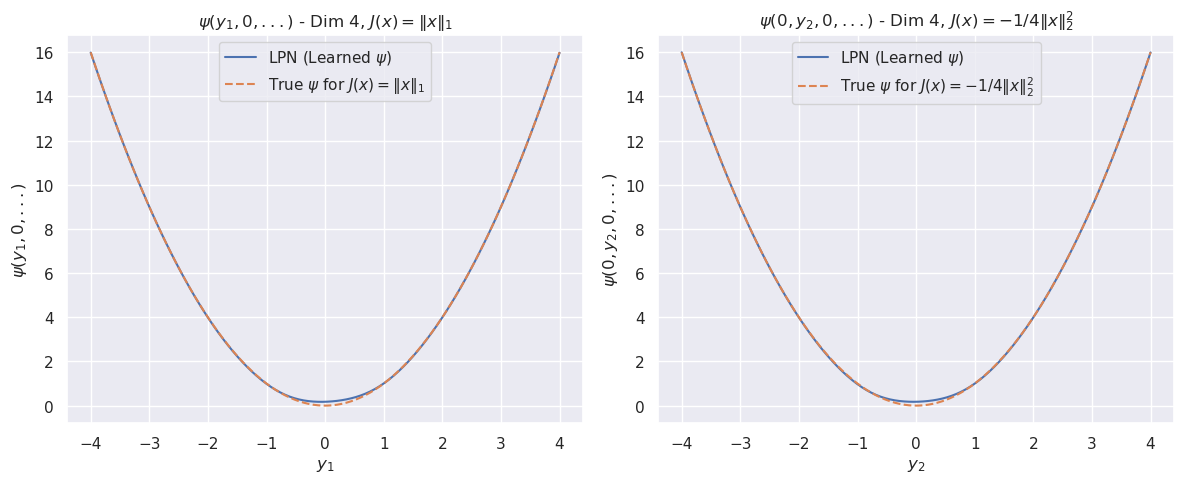

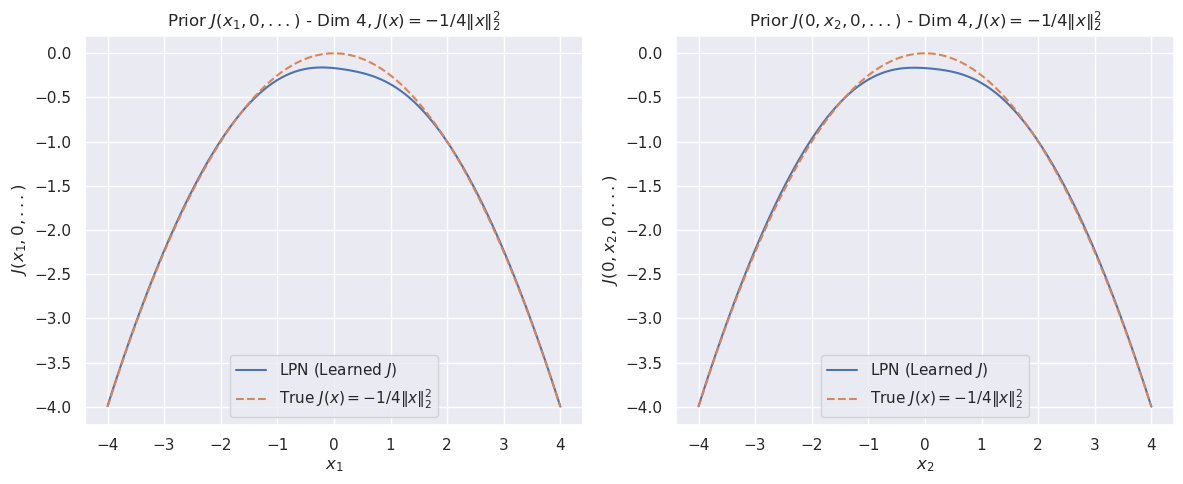

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3283,  3.5148, -7.9348, -3.1529],
        [-5.6377, -6.5237, -5.0092, -2.4652],
        [-1.6651,  0.6038, -1.2948,  2.9858],
        ...,
        [ 6.8101, -2.3528,  1.0563, -3.8091],
        [-7.2376, -7.3980, -5.1663, -7.9045],
        [ 2.5721,  6.4705,  6.5860,  2.7249]], device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 572.3488159179688
iteration 0 loss 3113.11865234375


iteration 500 loss 17.524078369140625


iteration 1000 loss 4.89727258682251


iteration 1500 loss 0.19599469006061554


iteration 2000 loss 0.08151283115148544


iteration 2500 loss 0.041773680597543716


iteration 3000 loss 0.026613488793373108


iteration 3500 loss 0.018411479890346527


iteration 4000 loss 0.02552991360425949


iteration 4500 loss 0.015237804502248764


iteration 5000 loss 0.010862925089895725


iteration 5500 loss 0.009987984783947468


iteration 6000 loss 0.01132663432508707


iteration 6500 loss 0.007258301135152578


iteration 7000 loss 0.008027194067835808


iteration 7500 loss 0.005461509805172682


iteration 8000 loss 0.0053594158962368965


iteration 8500 loss 0.005336119793355465


iteration 9000 loss 0.005825062282383442


iteration 9500 loss 0.01925124228000641


iteration 10000 loss 2.8841373920440674


iteration 10500 loss 0.0034997286275029182


iteration 11000 loss 0.0034921797923743725


iteration 11500 loss 0.0038354708813130856


iteration 12000 loss 0.016166038811206818


iteration 12500 loss 0.0030792891047894955


iteration 13000 loss 0.06488711386919022


iteration 13500 loss 0.00275024282746017


iteration 14000 loss 0.0709272027015686


iteration 14500 loss 0.0025418195873498917


iteration 15000 loss 0.2388579249382019


iteration 15500 loss 0.002373023657128215


iteration 16000 loss 0.006560690701007843


iteration 16500 loss 0.002161371987313032


iteration 17000 loss 2.7229151725769043


iteration 17500 loss 0.0021723411045968533


iteration 18000 loss 0.0018954896368086338


iteration 18500 loss 0.0020511681213974953


iteration 19000 loss 0.001770148053765297


iteration 19500 loss 0.002040271647274494


iteration 20000 loss 0.0017396510811522603


iteration 20500 loss 0.0032643387094140053


iteration 21000 loss 0.0017814795719459653


iteration 21500 loss 0.0015986053040251136


iteration 22000 loss 0.007487670052796602


iteration 22500 loss 0.0018894904060289264


iteration 23000 loss 0.001690634060651064


iteration 23500 loss 0.0015413508517667651


iteration 24000 loss 0.009795972146093845


iteration 24500 loss 0.001850048778578639


iteration 25000 loss 0.0015855457168072462


iteration 25500 loss 0.0014396337792277336


iteration 26000 loss 0.0013451774138957262


iteration 26500 loss 0.01682901754975319


iteration 27000 loss 0.0016245940933004022


iteration 27500 loss 0.0015033617382869124


iteration 28000 loss 0.0014121482381597161


iteration 28500 loss 0.0013302930165082216


iteration 29000 loss 0.0012592620914801955


iteration 29500 loss 0.001211135066114366


iteration 30000 loss 0.03983999416232109


iteration 30500 loss 0.002049593720585108


iteration 31000 loss 0.001513667986728251


iteration 31500 loss 0.0014237604336813092


iteration 32000 loss 0.0014073841739445925


iteration 32500 loss 0.0013191241305321455


iteration 33000 loss 0.0013239809777587652


iteration 33500 loss 0.0013062728103250265


iteration 34000 loss 0.0013045801315456629


iteration 34500 loss 0.0012891765218228102


iteration 35000 loss 0.0012711648596450686


iteration 35500 loss 0.0012690296862274408


iteration 36000 loss 0.0012044509639963508


iteration 36500 loss 0.0013522094814106822


iteration 37000 loss 0.0009652784210629761


iteration 37500 loss 0.00098335777875036


iteration 38000 loss 0.0009684939868748188


iteration 38500 loss 0.0009497920982539654


iteration 39000 loss 0.0009599424083717167


iteration 39500 loss 0.0009311741450801492


iteration 40000 loss 0.0009310237364843488


iteration 40500 loss 0.0009207261609844863


iteration 41000 loss 0.000910074042622


iteration 41500 loss 0.0009015028481371701


iteration 42000 loss 0.0008917419472709298


iteration 42500 loss 0.0008829450234770775


iteration 43000 loss 0.0008817588677629828


iteration 43500 loss 0.0008774264133535326


iteration 44000 loss 0.0008706961525604129


iteration 44500 loss 0.0008470377651974559


iteration 45000 loss 0.0008399314829148352


iteration 45500 loss 0.0008351844735443592


iteration 46000 loss 0.0008379907230846584


iteration 46500 loss 0.0008398054633289576


iteration 47000 loss 0.0008412719471380115


iteration 47500 loss 0.000914918608032167


iteration 48000 loss 0.355441153049469


iteration 48500 loss 0.0007853072602301836


iteration 49000 loss 0.0007862010970711708


iteration 49500 loss 0.0007901766803115606


iteration 50000 loss 0.0007724572205916047


iteration 50500 loss 0.0007825338398106396


iteration 51000 loss 0.0008003612165339291


iteration 51500 loss 0.0008088502800092101


iteration 52000 loss 0.0008180207805708051


iteration 52500 loss 0.0007378290756605566


iteration 53000 loss 0.0007303382735699415


iteration 53500 loss 0.000730280124116689


iteration 54000 loss 0.00073660520138219


iteration 54500 loss 0.0007399755995720625


iteration 55000 loss 0.0007414480205625296


iteration 55500 loss 0.0007508822018280625


iteration 56000 loss 0.0007782072061672807


iteration 56500 loss 0.00141011958476156


iteration 57000 loss 0.0006853708764538169


iteration 57500 loss 0.0006908143986947834


iteration 58000 loss 0.0006877796840853989


iteration 58500 loss 0.0006878988351672888


iteration 59000 loss 0.0006845039897598326


iteration 59500 loss 0.000683152349665761


iteration 60000 loss 0.0006911773234605789


iteration 60500 loss 0.0006984712672419846


iteration 61000 loss 0.0006952887633815408


iteration 61500 loss 0.0007016457384452224


iteration 62000 loss 0.0007092777523212135


iteration 62500 loss 0.0007127871504053473


iteration 63000 loss 0.0007083145319484174


iteration 63500 loss 0.000697295181453228


iteration 64000 loss 0.0007063199882395566


iteration 64500 loss 0.0007303562015295029


iteration 65000 loss 0.0007272572256624699


iteration 65500 loss 0.0007282833103090525


iteration 66000 loss 0.0006624183733947575


iteration 66500 loss 0.0006455527618527412


iteration 67000 loss 0.0006441212608478963


iteration 67500 loss 0.0006487314822152257


iteration 68000 loss 0.0006551286205649376


iteration 68500 loss 0.0006715210038237274


iteration 69000 loss 0.0006995673757046461


iteration 69500 loss 0.0012190574780106544


iteration 70000 loss 0.0005961529677733779


iteration 70500 loss 0.000596567231696099


iteration 71000 loss 0.0005998500855639577


iteration 71500 loss 0.0005968914483673871


iteration 72000 loss 0.0005952969659119844


iteration 72500 loss 0.0005949648912064731


iteration 73000 loss 0.000596756290178746


iteration 73500 loss 0.0006041273009032011


iteration 74000 loss 0.0006054646801203489


iteration 74500 loss 0.0006015779217705131


iteration 75000 loss 0.0006021758890710771


iteration 75500 loss 0.0006135267321951687


iteration 76000 loss 0.000612676318269223


iteration 76500 loss 0.0006087171495892107


iteration 77000 loss 0.0006210548453964293


iteration 77500 loss 0.0007246975437738001


iteration 78000 loss 0.06314727663993835


iteration 78500 loss 0.0005569423083215952


iteration 79000 loss 0.0005564010352827609


iteration 79500 loss 0.000556158076506108


iteration 80000 loss 0.0005548482877202332


iteration 80500 loss 0.0005532560753636062


iteration 81000 loss 0.0005509011680260301


iteration 81500 loss 0.0005508398171514273


iteration 82000 loss 0.0005504174041561782


iteration 82500 loss 0.0005514895310625434


iteration 83000 loss 0.0005509710172191262


iteration 83500 loss 0.0005531124188564718


iteration 84000 loss 0.0005529855843633413


iteration 84500 loss 0.0005559033015742898


iteration 85000 loss 0.0005596252740360796


iteration 85500 loss 0.0005617814022116363


iteration 86000 loss 0.0005628858925774693


iteration 86500 loss 0.0005683297640644014


iteration 87000 loss 0.0005900708492845297


iteration 87500 loss 0.0008379697683267295


iteration 88000 loss 0.16644535958766937


iteration 88500 loss 0.028951900079846382


iteration 89000 loss 0.0008529647602699697


iteration 89500 loss 0.0009018293349072337


iteration 90000 loss 0.0007621334516443312


iteration 90500 loss 0.0006061908788979053


iteration 91000 loss 0.0005554750678129494


iteration 91500 loss 0.0005455809296108782


iteration 92000 loss 0.0005108683253638446


iteration 92500 loss 0.5360844731330872


iteration 93000 loss 0.0007354442495852709


iteration 93500 loss 0.0005408853176049888


iteration 94000 loss 0.0005299512995406985


iteration 94500 loss 0.0005293819704093039


iteration 95000 loss 0.0005213004187680781


iteration 95500 loss 0.0005148203927092254


iteration 96000 loss 0.0005107067991048098


iteration 96500 loss 0.0005062195705249906


iteration 97000 loss 0.0005015020142309368


iteration 97500 loss 0.0004994727787561715


iteration 98000 loss 0.0004998039221391082


iteration 98500 loss 0.0004963784012943506


iteration 99000 loss 0.0004946718108840287


iteration 99500 loss 0.0004951994051225483


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.000491579354275018


iteration 100500 loss 0.0004872391000390053


iteration 101000 loss 0.0004824750649277121


iteration 101500 loss 0.0004772187676280737


iteration 102000 loss 0.0004714153183158487


iteration 102500 loss 0.000464969634776935


iteration 103000 loss 0.00045777764171361923


iteration 103500 loss 0.0004497347690630704


iteration 104000 loss 0.00044035210157744586


iteration 104500 loss 0.0004292899393476546


iteration 105000 loss 0.0004196612862870097


iteration 105500 loss 0.0004125697014387697


iteration 106000 loss 0.00040511522092856467


iteration 106500 loss 0.00039940414717420936


iteration 107000 loss 0.00039339455543085933


iteration 107500 loss 0.00039200804894790053


iteration 108000 loss 0.00038273463724181056


iteration 108500 loss 0.0003780029946938157


iteration 109000 loss 0.0003735833743121475


iteration 109500 loss 0.00036902737338095903


iteration 110000 loss 0.0004418395401444286


iteration 110500 loss 0.00036102093872614205


iteration 111000 loss 0.0003569646505638957


iteration 111500 loss 0.00035356380976736546


iteration 112000 loss 0.00035026605473831296


iteration 112500 loss 0.000347074557794258


iteration 113000 loss 0.0003437963023316115


iteration 113500 loss 0.0003408936026971787


iteration 114000 loss 0.0003380474809091538


iteration 114500 loss 0.0011560305720195174


iteration 115000 loss 0.00033195456489920616


iteration 115500 loss 0.00032900518272072077


iteration 116000 loss 0.0003265643026679754


iteration 116500 loss 0.00032390098203904927


iteration 117000 loss 0.0003224709362257272


iteration 117500 loss 0.00031902259797789156


iteration 118000 loss 0.010569138452410698


iteration 118500 loss 0.0003145968948956579


iteration 119000 loss 0.00031214309274218976


iteration 119500 loss 0.0003100492467638105


iteration 120000 loss 0.0003080267633777112


iteration 120500 loss 0.0003059139708057046


iteration 121000 loss 0.0003038558061234653


iteration 121500 loss 0.0009587776730768383


iteration 122000 loss 0.0002997378178406507


iteration 122500 loss 0.00029764484497718513


iteration 123000 loss 0.0002959847915917635


iteration 123500 loss 0.00029391798307187855


iteration 124000 loss 0.00029264300246722996


iteration 124500 loss 0.00029084424022585154


iteration 125000 loss 0.00028898060554638505


iteration 125500 loss 0.0002874349302146584


iteration 126000 loss 0.00028586992993950844


iteration 126500 loss 0.000284005916910246


iteration 127000 loss 0.0002824966795742512


iteration 127500 loss 0.00028058583848178387


iteration 128000 loss 0.0002793446183204651


iteration 128500 loss 0.00027772592147812247


iteration 129000 loss 0.00027645615045912564


iteration 129500 loss 0.0002748497063294053


iteration 130000 loss 0.0002735206508077681


iteration 130500 loss 0.00027339684311300516


iteration 131000 loss 0.0002708157117012888


iteration 131500 loss 0.0002692656416911632


iteration 132000 loss 0.00026825390523299575


iteration 132500 loss 0.00026817701291292906


iteration 133000 loss 0.00026555461226962507


iteration 133500 loss 0.00026497564977034926


iteration 134000 loss 0.000263038877164945


iteration 134500 loss 0.0002616951533127576


iteration 135000 loss 0.0002604180190246552


iteration 135500 loss 0.0002592000528238714


iteration 136000 loss 0.0002579001011326909


iteration 136500 loss 0.00025685675791464746


iteration 137000 loss 0.00025567482225596905


iteration 137500 loss 0.00025834800908342004


iteration 138000 loss 0.00025366328191012144


iteration 138500 loss 0.0002524640876799822


iteration 139000 loss 0.0002513256622478366


iteration 139500 loss 0.00025007882504723966


iteration 140000 loss 0.0002492686326149851


iteration 140500 loss 0.00024809708702377975


iteration 141000 loss 0.0002473148924764246


iteration 141500 loss 0.0002462378761265427


iteration 142000 loss 0.0002452403132338077


iteration 142500 loss 0.0002440685493638739


iteration 143000 loss 0.00024305366969201714


iteration 143500 loss 0.0011345308739691973


iteration 144000 loss 0.00024104720796458423


iteration 144500 loss 0.000240246721659787


iteration 145000 loss 0.00023925652203615755


iteration 145500 loss 0.0002381822996539995


iteration 146000 loss 0.00023746886290609837


iteration 146500 loss 0.0019489623373374343


iteration 147000 loss 0.0002354221505811438


iteration 147500 loss 0.00023456534836441278


iteration 148000 loss 0.00023359805345535278


iteration 148500 loss 0.00023270034580491483


iteration 149000 loss 0.00023176564718596637


iteration 149500 loss 0.0002309047122253105


iteration 150000 loss 0.006764736957848072


iteration 150500 loss 0.00022906772210262716


iteration 151000 loss 0.00022830828675068915


iteration 151500 loss 0.0002273529244121164


iteration 152000 loss 0.00022671536135021597


iteration 152500 loss 0.0002258150780107826


iteration 153000 loss 0.00022518172045238316


iteration 153500 loss 0.00022431739489547908


iteration 154000 loss 0.00022366702614817768


iteration 154500 loss 0.0002227823861176148


iteration 155000 loss 0.00022190541494637728


iteration 155500 loss 0.00022122764494270086


iteration 156000 loss 0.00022034472203813493


iteration 156500 loss 0.00021964077313896269


iteration 157000 loss 0.00021887449838686734


iteration 157500 loss 0.00021846417803317308


iteration 158000 loss 0.00021985954663250595


iteration 158500 loss 0.0002165323676308617


iteration 159000 loss 0.000215787353226915


iteration 159500 loss 0.00021636545716319233


iteration 160000 loss 0.00022321492724586278


iteration 160500 loss 0.00021364583517424762


iteration 161000 loss 0.0002128529449691996


iteration 161500 loss 0.0002122940932167694


iteration 162000 loss 0.00021153077250346541


iteration 162500 loss 0.0002108655171468854


iteration 163000 loss 0.00021010560158174485


iteration 163500 loss 0.00020948561723344028


iteration 164000 loss 0.00020870922890026122


iteration 164500 loss 0.00020820026111323386


iteration 165000 loss 0.00020745345682371408


iteration 165500 loss 0.00020691823738161474


iteration 166000 loss 0.00020618886628653854


iteration 166500 loss 0.00020570313790813088


iteration 167000 loss 0.00020499934908002615


iteration 167500 loss 0.00020445270638447255


iteration 168000 loss 0.0002037518279394135


iteration 168500 loss 0.00020320725161582232


iteration 169000 loss 0.0002024791610892862


iteration 169500 loss 0.00020201673032715917


iteration 170000 loss 0.00020130757184233516


iteration 170500 loss 0.00020079815294593573


iteration 171000 loss 0.00020320482144597918


iteration 171500 loss 0.0001995754719246179


iteration 172000 loss 0.0001989846205106005


iteration 172500 loss 0.0001984504924621433


iteration 173000 loss 0.00020422882516868412


iteration 173500 loss 0.0001973245816770941


iteration 174000 loss 0.000196612803847529


iteration 174500 loss 0.0001959929068107158


iteration 175000 loss 0.00019553073798306286


iteration 175500 loss 0.00019523482478689402


iteration 176000 loss 0.00019447843078523874


iteration 176500 loss 0.00019386396161280572


iteration 177000 loss 0.00019319934654049575


iteration 177500 loss 0.0001928659330587834


iteration 178000 loss 0.00019225630967412144


iteration 178500 loss 0.00019186086137779057


iteration 179000 loss 0.0001912488223752007


iteration 179500 loss 0.00019070196140091866


iteration 180000 loss 0.0001902739459183067


iteration 180500 loss 0.00018966084462590516


iteration 181000 loss 0.00018910871585831046


iteration 181500 loss 0.0001885619858512655


iteration 182000 loss 0.00018806215666700155


iteration 182500 loss 0.00018760132661554962


iteration 183000 loss 0.0001869799307314679


iteration 183500 loss 0.00018652847211342305


iteration 184000 loss 0.00018594201537780464


iteration 184500 loss 0.00018551545508671552


iteration 185000 loss 0.00018510963127482682


iteration 185500 loss 0.00018453362281434238


iteration 186000 loss 0.00018398553947918117


iteration 186500 loss 0.00018353780615143478


iteration 187000 loss 0.00019295381207484752


iteration 187500 loss 0.00018272065790370107


iteration 188000 loss 0.00018210597045253962


iteration 188500 loss 0.00018295746122021228


iteration 189000 loss 0.00020231730013620108


iteration 189500 loss 0.0001805920765036717


iteration 190000 loss 0.0003219475329387933


iteration 190500 loss 0.0002480667899362743


iteration 191000 loss 0.00017917389050126076


iteration 191500 loss 0.00017877404752653092


iteration 192000 loss 0.00029372749850153923


iteration 192500 loss 0.0003651343868114054


iteration 193000 loss 0.0001772766117937863


iteration 193500 loss 0.0001768065121723339


iteration 194000 loss 0.00017638203280512244


iteration 194500 loss 0.0001760075829224661


iteration 195000 loss 0.0001754696568241343


iteration 195500 loss 0.0001750621449900791


iteration 196000 loss 0.00024223791842814535


iteration 196500 loss 0.00021998457668814808


iteration 197000 loss 0.00017372009460814297


iteration 197500 loss 0.00017327869136352092


iteration 198000 loss 0.0001728818315314129


iteration 198500 loss 0.00017338161705993116


iteration 199000 loss 0.00017203499737661332


iteration 199500 loss 0.00017153775843326002


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00017114785441663116


iteration 200500 loss 0.0001710937503958121


iteration 201000 loss 0.00017102548736147583


iteration 201500 loss 0.00017094178474508226


iteration 202000 loss 0.0001708336640149355


iteration 202500 loss 0.00017069514433387667


iteration 203000 loss 0.00017052431940101087


iteration 203500 loss 0.00017030161689035594


iteration 204000 loss 0.00017002066306304187


iteration 204500 loss 0.00016966377734206617


iteration 205000 loss 0.0001758788712322712


iteration 205500 loss 0.000168761340319179


iteration 206000 loss 0.00016834713460411876


iteration 206500 loss 0.00016791287634987384


iteration 207000 loss 0.00016754122043494135


iteration 207500 loss 0.00016720817075110972


iteration 208000 loss 0.0001667531323619187


iteration 208500 loss 0.000166329147759825


iteration 209000 loss 0.00016595028864685446


iteration 209500 loss 0.0001655246305745095


iteration 210000 loss 0.0001651138736633584


iteration 210500 loss 0.0001647073804633692


iteration 211000 loss 0.00016438936290796846


iteration 211500 loss 0.00016398918523918837


iteration 212000 loss 0.00016361831512767822


iteration 212500 loss 0.00016325555043295026


iteration 213000 loss 0.00016285419405903667


iteration 213500 loss 0.00016246717132162303


iteration 214000 loss 0.00016204596613533795


iteration 214500 loss 0.00016167455760296434


iteration 215000 loss 0.00016140469233505428


iteration 215500 loss 0.00016097309708129615


iteration 216000 loss 0.00016061923815868795


iteration 216500 loss 0.00016023141506593674


iteration 217000 loss 0.00015991822874639183


iteration 217500 loss 0.00019113898451905698


iteration 218000 loss 0.00015915557742118835


iteration 218500 loss 0.0001587954757269472


iteration 219000 loss 0.00015843214350752532


iteration 219500 loss 0.00015806157898623496


iteration 220000 loss 0.000157786431373097


iteration 220500 loss 0.00015743433323223144


iteration 221000 loss 0.00015706672274973243


iteration 221500 loss 0.00015679458738304675


iteration 222000 loss 0.00015644889208488166


iteration 222500 loss 0.00015610925038345158


iteration 223000 loss 0.00015577465819660574


iteration 223500 loss 0.00015542242908850312


iteration 224000 loss 0.00015507033094763756


iteration 224500 loss 0.0001547393767395988


iteration 225000 loss 0.0001543777616461739


iteration 225500 loss 0.00015401665586978197


iteration 226000 loss 0.00015371543122455478


iteration 226500 loss 0.00015333486953750253


iteration 227000 loss 0.00015306704153772444


iteration 227500 loss 0.00015273908502422273


iteration 228000 loss 0.00015239630010910332


iteration 228500 loss 0.00015209047705866396


iteration 229000 loss 0.00015181658091023564


iteration 229500 loss 0.00015145930228754878


iteration 230000 loss 0.00015113445988390595


iteration 230500 loss 0.00015076027193572372


iteration 231000 loss 0.00015048605564516038


iteration 231500 loss 0.00015020799764897674


iteration 232000 loss 0.00014985520101618022


iteration 232500 loss 0.0001495869946666062


iteration 233000 loss 0.00014932193153072149


iteration 233500 loss 0.0001489866990596056


iteration 234000 loss 0.00014869248843751848


iteration 234500 loss 0.00014835681940894574


iteration 235000 loss 0.00014805057435296476


iteration 235500 loss 0.00014772426220588386


iteration 236000 loss 0.0001474100281484425


iteration 236500 loss 0.00014710934192407876


iteration 237000 loss 0.00014678451407235116


iteration 237500 loss 0.00015071140660438687


iteration 238000 loss 0.00014618365094065666


iteration 238500 loss 0.00014654858387075365


iteration 239000 loss 0.00014557917893398553


iteration 239500 loss 0.00014533709327224642


iteration 240000 loss 0.00014500257384497672


iteration 240500 loss 0.00014510884648188949


iteration 241000 loss 0.0001443633809685707


iteration 241500 loss 0.00014412587916012853


iteration 242000 loss 0.0001438725012121722


iteration 242500 loss 0.00014354927407111973


iteration 243000 loss 0.00014331022975966334


iteration 243500 loss 0.0001430666889064014


iteration 244000 loss 0.00014275641296990216


iteration 244500 loss 0.00014249488594941795


iteration 245000 loss 0.00014226829807739705


iteration 245500 loss 0.0001419781765434891


iteration 246000 loss 0.00014171005750540644


iteration 246500 loss 0.00014148111222311854


iteration 247000 loss 0.00014118840044829994


iteration 247500 loss 0.0001409235701430589


iteration 248000 loss 0.00014064574497751892


iteration 248500 loss 0.00014037732034921646


iteration 249000 loss 0.00014006545825395733


iteration 249500 loss 0.0001398487074766308


iteration 250000 loss 0.00013961995136924088


iteration 250500 loss 0.00013932738511357456


iteration 251000 loss 0.00013908138498663902


iteration 251500 loss 0.0001388477539876476


iteration 252000 loss 0.00013855357246939093


iteration 252500 loss 0.00013832584954798222


iteration 253000 loss 0.00013934016169514507


iteration 253500 loss 0.00013777584536001086


iteration 254000 loss 0.00013752243830822408


iteration 254500 loss 0.00013726360339205712


iteration 255000 loss 0.00013699938426725566


iteration 255500 loss 0.00013674974616151303


iteration 256000 loss 0.00013648049207404256


iteration 256500 loss 0.00013621414836961776


iteration 257000 loss 0.00013597698125522584


iteration 257500 loss 0.00013570630108006299


iteration 258000 loss 0.00013546481204684824


iteration 258500 loss 0.00013523119559977204


iteration 259000 loss 0.0001349837111774832


iteration 259500 loss 0.0001347747747786343


iteration 260000 loss 0.00013454332656692713


iteration 260500 loss 0.0001342938921879977


iteration 261000 loss 0.00013408009544946253


iteration 261500 loss 0.00014372267469298095


iteration 262000 loss 0.00013361108722165227


iteration 262500 loss 0.00013335941184777766


iteration 263000 loss 0.00013311722432263196


iteration 263500 loss 0.00013288012996781617


iteration 264000 loss 0.00013264629524201155


iteration 264500 loss 0.00013243524881545454


iteration 265000 loss 0.00013217132072895765


iteration 265500 loss 0.00013198847591411322


iteration 266000 loss 0.00013177086657378823


iteration 266500 loss 0.0001315380068263039


iteration 267000 loss 0.00013133088941685855


iteration 267500 loss 0.00013108967687003314


iteration 268000 loss 0.00013085345563013107


iteration 268500 loss 0.00013063997903373092


iteration 269000 loss 0.00013039859186392277


iteration 269500 loss 0.00013019153266213834


iteration 270000 loss 0.00013001864135731012


iteration 270500 loss 0.00012979783059563488


iteration 271000 loss 0.00012957576836925


iteration 271500 loss 0.00013145482807885855


iteration 272000 loss 0.00012914612307213247


iteration 272500 loss 0.00012892486120108515


iteration 273000 loss 0.0001287115883314982


iteration 273500 loss 0.00012854738452006131


iteration 274000 loss 0.00012833857908844948


iteration 274500 loss 0.00012811414489988238


iteration 275000 loss 0.00012793170753866434


iteration 275500 loss 0.00012769953173119575


iteration 276000 loss 0.0001275117538170889


iteration 276500 loss 0.00012733931362163275


iteration 277000 loss 0.0001271228538826108


iteration 277500 loss 0.0001269139611395076


iteration 278000 loss 0.000126668659504503


iteration 278500 loss 0.0001265162427444011


iteration 279000 loss 0.0001263334706891328


iteration 279500 loss 0.00012612614955287427


iteration 280000 loss 0.00012590725964400917


iteration 280500 loss 0.00012569999671541154


iteration 281000 loss 0.0001255068782484159


iteration 281500 loss 0.0001252929214388132


iteration 282000 loss 0.00012508349027484655


iteration 282500 loss 0.00012488219363149256


iteration 283000 loss 0.0001246683532372117


iteration 283500 loss 0.00012445506581570953


iteration 284000 loss 0.0001242633443325758


iteration 284500 loss 0.00012403678556438535


iteration 285000 loss 0.00012387389142531902


iteration 285500 loss 0.00012368313036859035


iteration 286000 loss 0.00012347700248938054


iteration 286500 loss 0.0001233051298186183


iteration 287000 loss 0.00012310189777053893


iteration 287500 loss 0.00012287947174627334


iteration 288000 loss 0.00012270889419596642


iteration 288500 loss 0.00012251529551576823


iteration 289000 loss 0.000122320547234267


iteration 289500 loss 0.00012213349691592157


iteration 290000 loss 0.00012192947906441987


iteration 290500 loss 0.0001217658500536345


iteration 291000 loss 0.00012155721196904778


iteration 291500 loss 0.00012138684542151168


iteration 292000 loss 0.00012118903396185488


iteration 292500 loss 0.00012100523599656299


iteration 293000 loss 0.00012080249143764377


iteration 293500 loss 0.00012059021537424996


iteration 294000 loss 0.00012043287279084325


iteration 294500 loss 0.00012024687021039426


iteration 295000 loss 0.00012005096505163237


iteration 295500 loss 0.00011991235805908218


iteration 296000 loss 0.00011973764776485041


iteration 296500 loss 0.00011953584908042103


iteration 297000 loss 0.00011934945359826088


iteration 297500 loss 0.00011916251241927966


iteration 298000 loss 0.00011897199146915227


iteration 298500 loss 0.0001187806119560264


iteration 299000 loss 0.0001185948567581363


iteration 299500 loss 0.00011839308717753738


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00011822051601484418


iteration 300500 loss 0.00011820252984762192


iteration 301000 loss 0.00011817827180493623


iteration 301500 loss 0.00011814554454758763


iteration 302000 loss 0.00011810231080744416


iteration 302500 loss 0.00011804661335190758


iteration 303000 loss 0.00011797339539043605


iteration 303500 loss 0.00011787905532401055


iteration 304000 loss 0.00011775903112720698


iteration 304500 loss 0.00011760530469473451


iteration 305000 loss 0.00011740808258764446


iteration 305500 loss 0.00011724824435077608


iteration 306000 loss 0.00011709340469678864


iteration 306500 loss 0.00011689636448863894


iteration 307000 loss 0.00011673838889691979


iteration 307500 loss 0.00011654770059976727


iteration 308000 loss 0.00011638578871497884


iteration 308500 loss 0.00011622130841715261


iteration 309000 loss 0.00011602880840655416


iteration 309500 loss 0.00011588791676331311


iteration 310000 loss 0.0001157165170297958


iteration 310500 loss 0.0001155358986579813


iteration 311000 loss 0.00011536621605046093


iteration 311500 loss 0.00011518478277139366


iteration 312000 loss 0.0001150368552771397


iteration 312500 loss 0.00011484803690109402


iteration 313000 loss 0.00011470150639070198


iteration 313500 loss 0.00011453940533101559


iteration 314000 loss 0.00011436292697908357


iteration 314500 loss 0.0001142168985097669


iteration 315000 loss 0.00011403107055230066


iteration 315500 loss 0.00011388928396627307


iteration 316000 loss 0.00011372601875336841


iteration 316500 loss 0.00011355492461007088


iteration 317000 loss 0.00011340403580106795


iteration 317500 loss 0.00011322216596454382


iteration 318000 loss 0.00011307670501992106


iteration 318500 loss 0.00011290464317426085


iteration 319000 loss 0.00011276199802523479


iteration 319500 loss 0.00011259932216489688


iteration 320000 loss 0.0001124370755860582


iteration 320500 loss 0.00011229851224925369


iteration 321000 loss 0.00011212339450139552


iteration 321500 loss 0.0001119829248636961


iteration 322000 loss 0.0001118317450163886


iteration 322500 loss 0.00011166151671204716


iteration 323000 loss 0.00011151108628837392


iteration 323500 loss 0.00011134299711557105


iteration 324000 loss 0.00011120012641185895


iteration 324500 loss 0.00011102647840743884


iteration 325000 loss 0.00011089398321928456


iteration 325500 loss 0.00011073135101469234


iteration 326000 loss 0.00011058540985686705


iteration 326500 loss 0.00011045103019569069


iteration 327000 loss 0.0001102783644455485


iteration 327500 loss 0.00011014933261321858


iteration 328000 loss 0.00011001524399034679


iteration 328500 loss 0.00010984465916408226


iteration 329000 loss 0.00010971810843329877


iteration 329500 loss 0.00010955860489048064


iteration 330000 loss 0.0001094029430532828


iteration 330500 loss 0.0001092808015528135


iteration 331000 loss 0.00010912679135799408


iteration 331500 loss 0.00010897942411247641


iteration 332000 loss 0.00010883974755415693


iteration 332500 loss 0.00010867204400710762


iteration 333000 loss 0.00010854873107746243


iteration 333500 loss 0.00010839049355126917


iteration 334000 loss 0.00010825668141478673


iteration 334500 loss 0.00010812258551595733


iteration 335000 loss 0.00010950896103167906


iteration 335500 loss 0.00010783949983306229


iteration 336000 loss 0.00010769922664621845


iteration 336500 loss 0.00010754880349850282


iteration 337000 loss 0.00010741767619038001


iteration 337500 loss 0.00010726504115154967


iteration 338000 loss 0.00010713891970226541


iteration 338500 loss 0.00010699380072765052


iteration 339000 loss 0.00010685408051358536


iteration 339500 loss 0.00010671194468159229


iteration 340000 loss 0.00010656610538717359


iteration 340500 loss 0.00010644292342476547


iteration 341000 loss 0.00010628608288243413


iteration 341500 loss 0.00010616997315082699


iteration 342000 loss 0.00010604057024465874


iteration 342500 loss 0.00010588657460175455


iteration 343000 loss 0.00010576689237495884


iteration 343500 loss 0.00010561676026554778


iteration 344000 loss 0.00010549710714258254


iteration 344500 loss 0.00010536482295719907


iteration 345000 loss 0.00010521878721192479


iteration 345500 loss 0.00010510848369449377


iteration 346000 loss 0.00010496662434889004


iteration 346500 loss 0.0001048332778736949


iteration 347000 loss 0.0001047109326464124


iteration 347500 loss 0.00010455665324116126


iteration 348000 loss 0.00010444943472975865


iteration 348500 loss 0.00010432088311063126


iteration 349000 loss 0.00010417863813927397


iteration 349500 loss 0.00010406153160147369


iteration 350000 loss 0.0001039115377352573


iteration 350500 loss 0.00010379833838669583


iteration 351000 loss 0.00010367445793235675


iteration 351500 loss 0.00010353142715757713


iteration 352000 loss 0.00010342607129132375


iteration 352500 loss 0.00010328990902053192


iteration 353000 loss 0.00010316333646187559


iteration 353500 loss 0.00010303810267942026


iteration 354000 loss 0.00010290214413544163


iteration 354500 loss 0.00010278498666593805


iteration 355000 loss 0.0001026456811814569


iteration 355500 loss 0.00010253091750200838


iteration 356000 loss 0.00010238933464279398


iteration 356500 loss 0.00010227851453237236


iteration 357000 loss 0.00010215342626906931


iteration 357500 loss 0.0001020206545945257


iteration 358000 loss 0.00010191037290496752


iteration 358500 loss 0.00010176920477533713


iteration 359000 loss 0.00010165234562009573


iteration 359500 loss 0.0001015292145893909


iteration 360000 loss 0.00010140243830392137


iteration 360500 loss 0.00010126133565790951


iteration 361000 loss 0.00010115699842572212


iteration 361500 loss 0.0001010387422866188


iteration 362000 loss 0.00010090725118061528


iteration 362500 loss 0.00010080903302878141


iteration 363000 loss 0.00010068270785268396


iteration 363500 loss 0.0001005634039756842


iteration 364000 loss 0.0001004605510388501


iteration 364500 loss 0.00010032791760750115


iteration 365000 loss 0.0001002214994514361


iteration 365500 loss 0.00010010511323343962


iteration 366000 loss 9.997787128668278e-05


iteration 366500 loss 9.986905934056267e-05


iteration 367000 loss 9.973915439331904e-05


iteration 367500 loss 9.96355593088083e-05


iteration 368000 loss 9.95107984635979e-05


iteration 368500 loss 9.939679875969887e-05


iteration 369000 loss 9.92977584246546e-05


iteration 369500 loss 9.917052375385538e-05


iteration 370000 loss 9.906312334351242e-05


iteration 370500 loss 9.894855611491948e-05


iteration 371000 loss 9.881847654469311e-05


iteration 371500 loss 9.872300870483741e-05


iteration 372000 loss 9.86032682703808e-05


iteration 372500 loss 9.848308400250971e-05


iteration 373000 loss 9.839574340730906e-05


iteration 373500 loss 9.82827041298151e-05


iteration 374000 loss 9.815792873268947e-05


iteration 374500 loss 9.805802255868912e-05


iteration 375000 loss 9.793501521926373e-05


iteration 375500 loss 9.783353743841872e-05


iteration 376000 loss 9.772514749784023e-05


iteration 376500 loss 9.759937529452145e-05


iteration 377000 loss 9.750471508596092e-05


iteration 377500 loss 9.738600056152791e-05


iteration 378000 loss 9.727779251988977e-05


iteration 378500 loss 9.718302317196503e-05


iteration 379000 loss 9.706027776701376e-05


iteration 379500 loss 9.695655899122357e-05


iteration 380000 loss 9.685196710051969e-05


iteration 380500 loss 9.672661690274253e-05


iteration 381000 loss 9.663765376899391e-05


iteration 381500 loss 9.652598964748904e-05


iteration 382000 loss 9.641216456657276e-05


iteration 382500 loss 9.631730790715665e-05


iteration 383000 loss 9.619371849112213e-05


iteration 383500 loss 9.609766857465729e-05


iteration 384000 loss 9.598740871297196e-05


iteration 384500 loss 9.587212116457522e-05


iteration 385000 loss 9.577132732374594e-05


iteration 385500 loss 9.564604260958731e-05


iteration 386000 loss 9.555830911267549e-05


iteration 386500 loss 9.545506327413023e-05


iteration 387000 loss 9.533601405564696e-05


iteration 387500 loss 9.524529741611332e-05


iteration 388000 loss 9.513014811091125e-05


iteration 388500 loss 9.502084867563099e-05


iteration 389000 loss 9.489736112300307e-05


iteration 389500 loss 9.480785229243338e-05


iteration 390000 loss 9.470766235608608e-05


iteration 390500 loss 9.459049761062488e-05


iteration 391000 loss 9.449943172512576e-05


iteration 391500 loss 9.438984125154093e-05


iteration 392000 loss 9.427726035937667e-05


iteration 392500 loss 9.418908302905038e-05


iteration 393000 loss 9.407706238562241e-05


iteration 393500 loss 9.39722522161901e-05


iteration 394000 loss 9.387931640958413e-05


iteration 394500 loss 9.376068192068487e-05


iteration 395000 loss 9.366520680487156e-05


iteration 395500 loss 9.3557704531122e-05


iteration 396000 loss 9.344654972665012e-05


iteration 396500 loss 9.334918286185712e-05


iteration 397000 loss 9.323129779659212e-05


iteration 397500 loss 9.312124893767759e-05


iteration 398000 loss 9.301606769440696e-05


iteration 398500 loss 9.29034358705394e-05


iteration 399000 loss 9.280036465497687e-05


iteration 399500 loss 9.269510337617248e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 9.258493810193613e-05


iteration 400500 loss 9.257462079403922e-05


iteration 401000 loss 9.256281919078901e-05


iteration 401500 loss 9.254736505681649e-05


iteration 402000 loss 9.252605377696455e-05


iteration 402500 loss 9.249969298252836e-05


iteration 403000 loss 9.246486297342926e-05


iteration 403500 loss 9.242031228495762e-05


iteration 404000 loss 9.236623009201139e-05


iteration 404500 loss 9.230045543517917e-05


iteration 405000 loss 9.221956133842468e-05


iteration 405500 loss 9.212412260239944e-05


iteration 406000 loss 9.202508954331279e-05


iteration 406500 loss 9.192668949253857e-05


iteration 407000 loss 9.182876237900928e-05


iteration 407500 loss 9.172936552204192e-05


iteration 408000 loss 9.163239155896008e-05


iteration 408500 loss 9.153525024885312e-05


iteration 409000 loss 9.143607167061418e-05


iteration 409500 loss 9.133891580859199e-05


iteration 410000 loss 9.124408825300634e-05


iteration 410500 loss 9.114616841543466e-05


iteration 411000 loss 9.105056233238429e-05


iteration 411500 loss 9.095581481233239e-05


iteration 412000 loss 9.085971396416426e-05


iteration 412500 loss 9.07657595234923e-05


iteration 413000 loss 9.067210339708254e-05


iteration 413500 loss 9.057700663106516e-05


iteration 414000 loss 9.048358333529904e-05


iteration 414500 loss 9.038951247930527e-05


iteration 415000 loss 9.029670763993636e-05


iteration 415500 loss 9.020108700497076e-05


iteration 416000 loss 9.010932990349829e-05


iteration 416500 loss 9.001656871987507e-05


iteration 417000 loss 8.992399671114981e-05


iteration 417500 loss 8.983419684227556e-05


iteration 418000 loss 8.974302909336984e-05


iteration 418500 loss 8.964988228399307e-05


iteration 419000 loss 8.955877274274826e-05


iteration 419500 loss 8.947051537688822e-05


iteration 420000 loss 8.937969687394798e-05


iteration 420500 loss 8.928765601012856e-05


iteration 421000 loss 8.919664105633274e-05


iteration 421500 loss 8.910663746064529e-05


iteration 422000 loss 8.901696855900809e-05


iteration 422500 loss 8.892689947970212e-05


iteration 423000 loss 8.884102135198191e-05


iteration 423500 loss 8.875227649696171e-05


iteration 424000 loss 8.866204734658822e-05


iteration 424500 loss 8.85735935298726e-05


iteration 425000 loss 8.848543075146154e-05


iteration 425500 loss 8.839544170768932e-05


iteration 426000 loss 8.831168088363484e-05


iteration 426500 loss 8.822396193863824e-05


iteration 427000 loss 8.813512977212667e-05


iteration 427500 loss 8.804863318800926e-05


iteration 428000 loss 8.796040492597967e-05


iteration 428500 loss 8.787254773778841e-05


iteration 429000 loss 8.77847196534276e-05


iteration 429500 loss 8.769768464844674e-05


iteration 430000 loss 8.761103526921943e-05


iteration 430500 loss 8.752331632422283e-05


iteration 431000 loss 8.743684884393588e-05


iteration 431500 loss 8.735509618418291e-05


iteration 432000 loss 8.727042586542666e-05


iteration 432500 loss 8.718389290152118e-05


iteration 433000 loss 8.709776011528447e-05


iteration 433500 loss 8.701220212969929e-05


iteration 434000 loss 8.692606206750497e-05


iteration 434500 loss 8.683978376211599e-05


iteration 435000 loss 8.675509161548689e-05


iteration 435500 loss 8.666934445500374e-05


iteration 436000 loss 8.6585248936899e-05


iteration 436500 loss 8.650073141325265e-05


iteration 437000 loss 8.641545719001442e-05


iteration 437500 loss 8.633128891233355e-05


iteration 438000 loss 8.624809561297297e-05


iteration 438500 loss 8.616388367954642e-05


iteration 439000 loss 8.608074858784676e-05


iteration 439500 loss 8.599708962719887e-05


iteration 440000 loss 8.591249934397638e-05


iteration 440500 loss 8.582911686971784e-05


iteration 441000 loss 8.57454288052395e-05


iteration 441500 loss 8.566203177906573e-05


iteration 442000 loss 8.557986438972875e-05


iteration 442500 loss 8.549812628189102e-05


iteration 443000 loss 8.541610441170633e-05


iteration 443500 loss 8.533363143214956e-05


iteration 444000 loss 8.525141311110929e-05


iteration 444500 loss 8.516912930645049e-05


iteration 445000 loss 8.508843166055158e-05


iteration 445500 loss 8.50047217682004e-05


iteration 446000 loss 8.492465713061392e-05


iteration 446500 loss 8.484253339702263e-05


iteration 447000 loss 8.47609990159981e-05


iteration 447500 loss 8.467987208859995e-05


iteration 448000 loss 8.460032404400408e-05


iteration 448500 loss 8.451875328319147e-05


iteration 449000 loss 8.443965634796768e-05


iteration 449500 loss 8.435808558715507e-05


iteration 450000 loss 8.427865395788103e-05


iteration 450500 loss 8.419776713708416e-05


iteration 451000 loss 8.41173532535322e-05


iteration 451500 loss 8.403795800404623e-05


iteration 452000 loss 8.395971963182092e-05


iteration 452500 loss 8.38790656416677e-05


iteration 453000 loss 8.379953942494467e-05


iteration 453500 loss 8.372087177122012e-05


iteration 454000 loss 8.364296809304506e-05


iteration 454500 loss 8.356370381079614e-05


iteration 455000 loss 8.348537812707946e-05


iteration 455500 loss 8.340647764271125e-05


iteration 456000 loss 8.332914876518771e-05


iteration 456500 loss 8.325086673721671e-05


iteration 457000 loss 8.317347237607464e-05


iteration 457500 loss 8.309498662129045e-05


iteration 458000 loss 8.301710477098823e-05


iteration 458500 loss 8.293971768580377e-05


iteration 459000 loss 8.286166848847643e-05


iteration 459500 loss 8.278394670924172e-05


iteration 460000 loss 8.270686521427706e-05


iteration 460500 loss 8.26313262223266e-05


iteration 461000 loss 8.25536553747952e-05


iteration 461500 loss 8.247740333899856e-05


iteration 462000 loss 8.240070019382983e-05


iteration 462500 loss 8.232545951614156e-05


iteration 463000 loss 8.224810153478757e-05


iteration 463500 loss 8.217145659727976e-05


iteration 464000 loss 8.209537918446586e-05


iteration 464500 loss 8.201938908314332e-05


iteration 465000 loss 8.194464317057282e-05


iteration 465500 loss 8.1869016867131e-05


iteration 466000 loss 8.179393626051024e-05


iteration 466500 loss 8.171921945177019e-05


iteration 467000 loss 8.164421160472557e-05


iteration 467500 loss 8.156865806085989e-05


iteration 468000 loss 8.149206405505538e-05


iteration 468500 loss 8.141737635014579e-05


iteration 469000 loss 8.134313247865066e-05


iteration 469500 loss 8.126864122459665e-05


iteration 470000 loss 8.119431731756777e-05


iteration 470500 loss 8.111876377370209e-05


iteration 471000 loss 8.1044745456893e-05


iteration 471500 loss 8.097106911009178e-05


iteration 472000 loss 8.089791663223878e-05


iteration 472500 loss 8.08221593615599e-05


iteration 473000 loss 8.074866491369903e-05


iteration 473500 loss 8.067383168963715e-05


iteration 474000 loss 8.060023537836969e-05


iteration 474500 loss 8.05266754468903e-05


iteration 475000 loss 8.045361028052866e-05


iteration 475500 loss 8.037997031351551e-05


iteration 476000 loss 8.030531898839399e-05


iteration 476500 loss 8.023405825952068e-05


iteration 477000 loss 8.015998901100829e-05


iteration 477500 loss 8.008813892956823e-05


iteration 478000 loss 8.001428795978427e-05


iteration 478500 loss 7.994157203938812e-05


iteration 479000 loss 7.986899436218664e-05


iteration 479500 loss 7.979691145010293e-05


iteration 480000 loss 7.972494495334104e-05


iteration 480500 loss 7.965256372699514e-05


iteration 481000 loss 7.958019705256447e-05


iteration 481500 loss 7.950778672238812e-05


iteration 482000 loss 7.94356528786011e-05


iteration 482500 loss 7.936385372886434e-05


iteration 483000 loss 7.929273851914331e-05


iteration 483500 loss 7.922154327388853e-05


iteration 484000 loss 7.915020250948146e-05


iteration 484500 loss 7.907808321760967e-05


iteration 485000 loss 7.900810305727646e-05


iteration 485500 loss 7.893722067819908e-05


iteration 486000 loss 7.886451203376055e-05


iteration 486500 loss 7.87984172347933e-05


iteration 487000 loss 7.872686546761543e-05


iteration 487500 loss 7.865717634558678e-05


iteration 488000 loss 7.858529716031626e-05


iteration 488500 loss 7.85150405135937e-05


iteration 489000 loss 7.844526408007368e-05


iteration 489500 loss 7.837497105356306e-05


iteration 490000 loss 7.8304969065357e-05


iteration 490500 loss 7.823465421097353e-05


iteration 491000 loss 7.816450670361519e-05


iteration 491500 loss 7.809403905412182e-05


iteration 492000 loss 7.802471372997388e-05


iteration 492500 loss 7.795562851242721e-05


iteration 493000 loss 7.788649963913485e-05


iteration 493500 loss 7.781755994074047e-05


iteration 494000 loss 7.77470413595438e-05


iteration 494500 loss 7.767801434965804e-05


iteration 495000 loss 7.760846347082406e-05


iteration 495500 loss 7.753911631880328e-05


iteration 496000 loss 7.747072231722996e-05


iteration 496500 loss 7.740219007246196e-05


iteration 497000 loss 7.73337233113125e-05


iteration 497500 loss 7.726635521976277e-05


iteration 498000 loss 7.719625136815012e-05


iteration 498500 loss 7.71283739595674e-05


iteration 499000 loss 7.706072938162833e-05


iteration 499500 loss 7.69918187870644e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


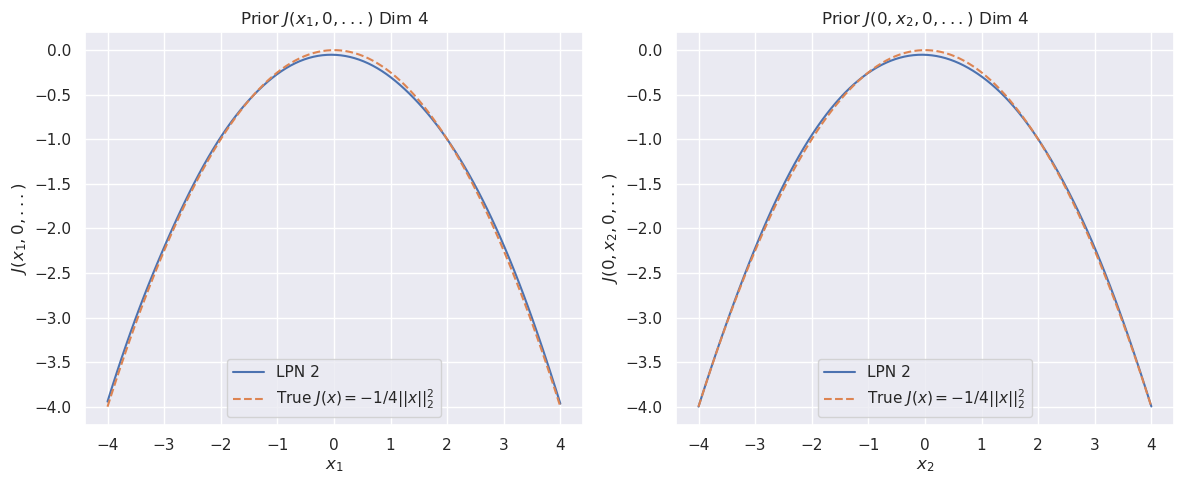

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)